In [146]:
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

pd.options.mode.use_inf_as_na = True
warnings.filterwarnings('ignore')
%matplotlib inline 

In [147]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [148]:
df_train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [149]:
df_train['batch'] = df_train.index//500000

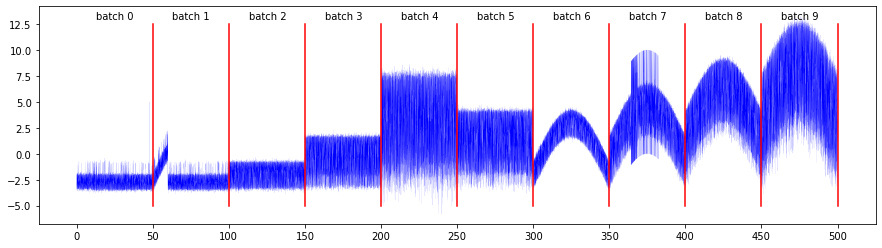

In [150]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['signal'],color='blue',linewidth=.05)

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red')
    axs.annotate(f'batch {batch}', xy = (x[0]-37,13))
    plt.xticks(np.arange(0, 501, 50))

In [151]:
df_train['remove_drift'] = df_train['signal'].values

In [152]:
df_batch_1 = df_train.loc[df_train['batch']==1].copy()

In [153]:
df_batch_1_1 = df_batch_1.loc[df_batch_1['time']<=60].copy()
df_batch_1_2 = df_batch_1.loc[df_batch_1['time']>60].copy()

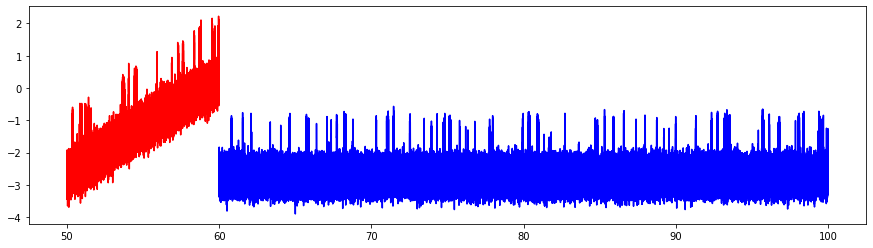

In [154]:
plt.subplots(figsize=(15, 4))
plt.plot(df_batch_1_1['time'], df_batch_1_1['signal'], '-r' )
plt.plot(df_batch_1_2['time'], df_batch_1_2['signal'], '-b' )

# Remove drift with sin func use

In [155]:
def my_sin(x, A, ph, d):
    frequency = 0.01 # 1/50*2 s  (50 is 1/2 T)
    omega = 2 * np.pi * frequency
    return A * np.sin(omega * x + ph) + d

In [156]:
popt, _ = curve_fit(my_sin, df_batch_1_1['time'], df_batch_1_1['signal'])

In [157]:
yy = my_sin(df_batch_1_1['time'],popt[0],popt[1],popt[2])

In [158]:
df_train.loc[500000:599999, 'remove_drift'] = (df_train.loc[500000:599999, 'signal'] - yy) + yy.values[0]

In [159]:
for batch in range(6,10):
    df_batch = df_train.loc[df_train['batch']==batch].copy()
    popt, _ = curve_fit(my_sin, df_batch['time'], df_batch['signal'])
    yy = my_sin(df_batch['time'],popt[0],popt[1],popt[2]) 
    
    df_train.loc[df_train['batch']==batch, 'remove_drift'] = (
        df_train.loc[df_train['batch']==batch, 'signal'] - yy) + yy.values[0]

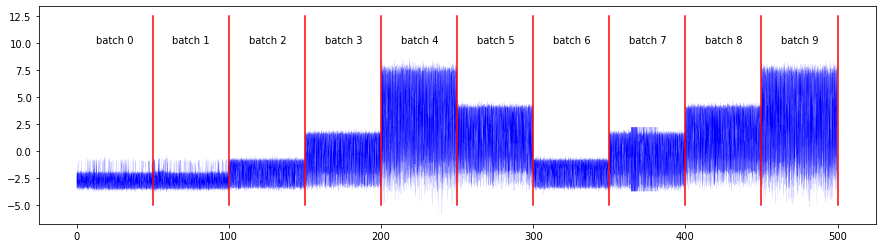

In [223]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['remove_drift'], linewidth=.05 ,color='blue')

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-37,10))

In [161]:
print(f'Размер тренировочного сета: {df_train.shape[0]} объектов')
print(f'Количество объектов в тренировочном сете где целевая переменная больше нуля: {df_train.loc[df_train["open_channels"]>0].shape[0]}')
print(f'Количество уникальных signal: {df_train["remove_drift"].unique().shape[0]}')      

Размер тренировочного сета: 5000000 объектов
Количество объектов в тренировочном сете где целевая переменная больше нуля: 3759848
Количество уникальных signal: 2173200


In [162]:
df_train.describe()

,time,signal,open_channels,batch,remove_drift
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00,4.500000e+00,7.302049e-02
std,1.443376e+02,3.336219e+00,2.665051e+00,2.872282e+00,2.478891e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00,0.000000e+00,-5.796500e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00,2.000000e+00,-2.104000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00,4.500000e+00,-3.375916e-01
75%,3.750000e+02,3.690100e+00,4.000000e+00,7.000000e+00,1.972264e+00
max,5.000000e+02,1.324400e+01,1.000000e+01,9.000000e+00,8.613100e+00


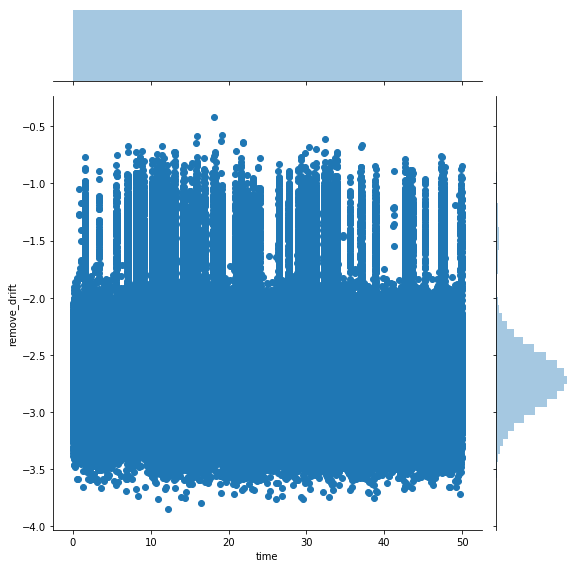

In [165]:
sns.jointplot(x = 'time', y= 'remove_drift', data = df_train.loc[df_train['batch']==0], height=8)
plt.show()

In [164]:
df_train.drop(df_train.loc[(df_train['batch']==0)&(df_train['remove_drift']>0)].index, inplace = True)

In [20]:
df_train.loc[df_train['batch']==3]['remove_drift'].describe()

count    500000.000000
mean         -0.092984
std           1.002793
min          -3.707300
25%          -0.592000
50%          -0.134000
75%           0.830400
max           2.240400
Name: remove_drift, dtype: float64

In [21]:
# Если просто удалять
df_train.drop(df_train.loc[(df_train['batch']==7)&(df_train['remove_drift']>2.240400)].index, inplace = True)
df_train.drop(df_train.loc[(df_train['batch']==7)&(df_train['remove_drift']<-3.707300)].index, inplace = True)

In [22]:
df_train.loc[df_train['batch']==7]['remove_drift'].describe()

count    492191.000000
mean         -0.173239
std           1.031254
min          -3.707196
25%          -0.710025
50%          -0.193945
75%           0.756909
max           2.239753
Name: remove_drift, dtype: float64

(array([1239949.,  984487.,  550613.,  665689.,  403410.,  277877.,
         188112.,  265015.,  245183.,  171853.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

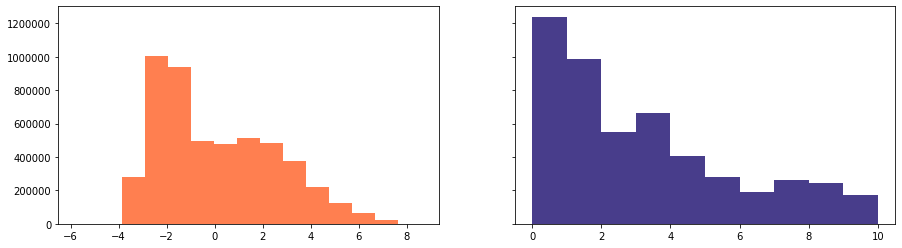

In [23]:
count, bin_signal = np.histogram(df_train['remove_drift'], 15)
count, bin_number = np.histogram(df_train['open_channels'], 10)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
axs[0].hist(df_train['remove_drift'],
            bins=bin_signal,
            color='coral')
axs[1].hist(df_train['open_channels'],
            bins=bin_number,
            color='darkslateblue')

Text(0.5, 0.98, 'Counts number open channel')

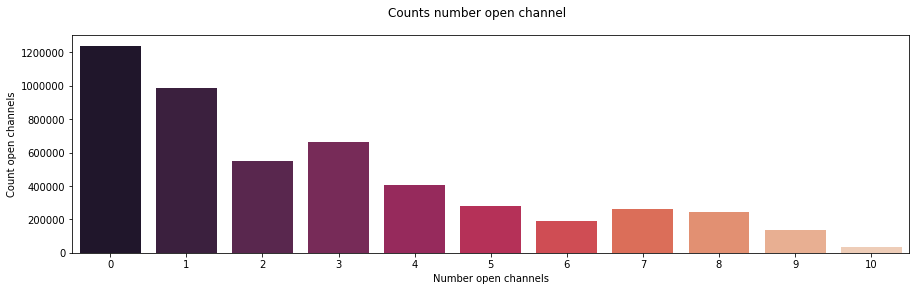

In [24]:
# Подсчет целевых значений
df_number_chan = df_train['open_channels'].value_counts().to_frame().reset_index()
df_number_chan.rename(columns={'index': 'number_open_channels','open_channels':'count_open_channels'}, inplace=True)

fig, axs = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
sns.barplot(x=df_number_chan['number_open_channels'], y=df_number_chan['count_open_channels'], palette="rocket", ax=axs)
#axs.bar(df_number_chan['number_open_channels'], df_number_chan['count_open_channels'])
plt.ylabel('Count open channels')
plt.xlabel('Number open channels')
fig.suptitle('Counts number open channel')

In [25]:
# date for bild heatmap
count, bin_signal = np.histogram(df_train['remove_drift'], 11)
dict_heatmap = {}
list_heatmap = []

for bin_index in range(11):
    
    for open_channels in  range(11):
        dict_heatmap['bin'] = round(bin_signal[bin_index+1])
        dict_heatmap['number_open_channels'] = open_channels
        dict_heatmap['count_open_channels'] = df_train.loc[(df_train['open_channels']==open_channels)
                     &(df_train['remove_drift']>bin_signal[bin_index])
                     &(df_train['remove_drift']<bin_signal[bin_index+1])
                     ,'open_channels'].count()
        list_heatmap.append(dict_heatmap.copy())

In [26]:
df_heatmap = pd.DataFrame(list_heatmap)
df_heatmap = df_heatmap.pivot('bin', 'number_open_channels', 'count_open_channels')

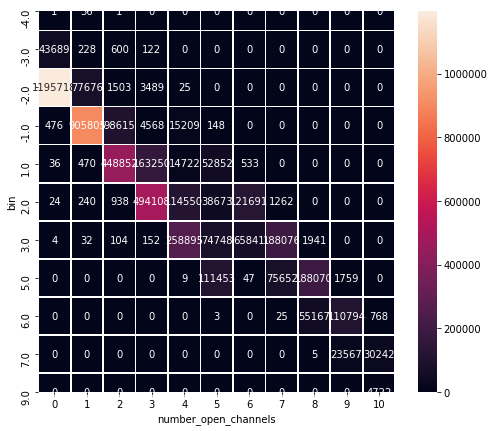

In [27]:
fig, axs = plt.subplots(figsize=(8, 7))
sns.heatmap(df_heatmap, annot=True, fmt="d", linewidths=.8, ax=axs)

In [28]:
list_df_heatmap = []

for batch in range(10):
    dict_heatmap = {}
    list_heatmap = []
    df_train_batch = df_train.loc[df_train['batch']==batch].copy()
    count, bin_signal = np.histogram(df_train_batch['remove_drift'], 4)
    for bin_index in range(4):       
        for open_channels in  range(11):
            dict_heatmap['bin_signal'] = round(bin_signal[bin_index+1])
            dict_heatmap['number_open_channels'] = open_channels
            dict_heatmap['count_open_channels'] = df_train_batch.loc[(df_train['open_channels']==open_channels)
                         &(df_train['remove_drift']>bin_signal[bin_index])
                         &(df_train['remove_drift']<bin_signal[bin_index+1])
                         ,'open_channels'].count()
            list_heatmap.append(dict_heatmap.copy())
    df_heatmap = pd.DataFrame(list_heatmap)
    list_df_heatmap.append(df_heatmap.pivot('bin_signal', 'number_open_channels', 'count_open_channels'))

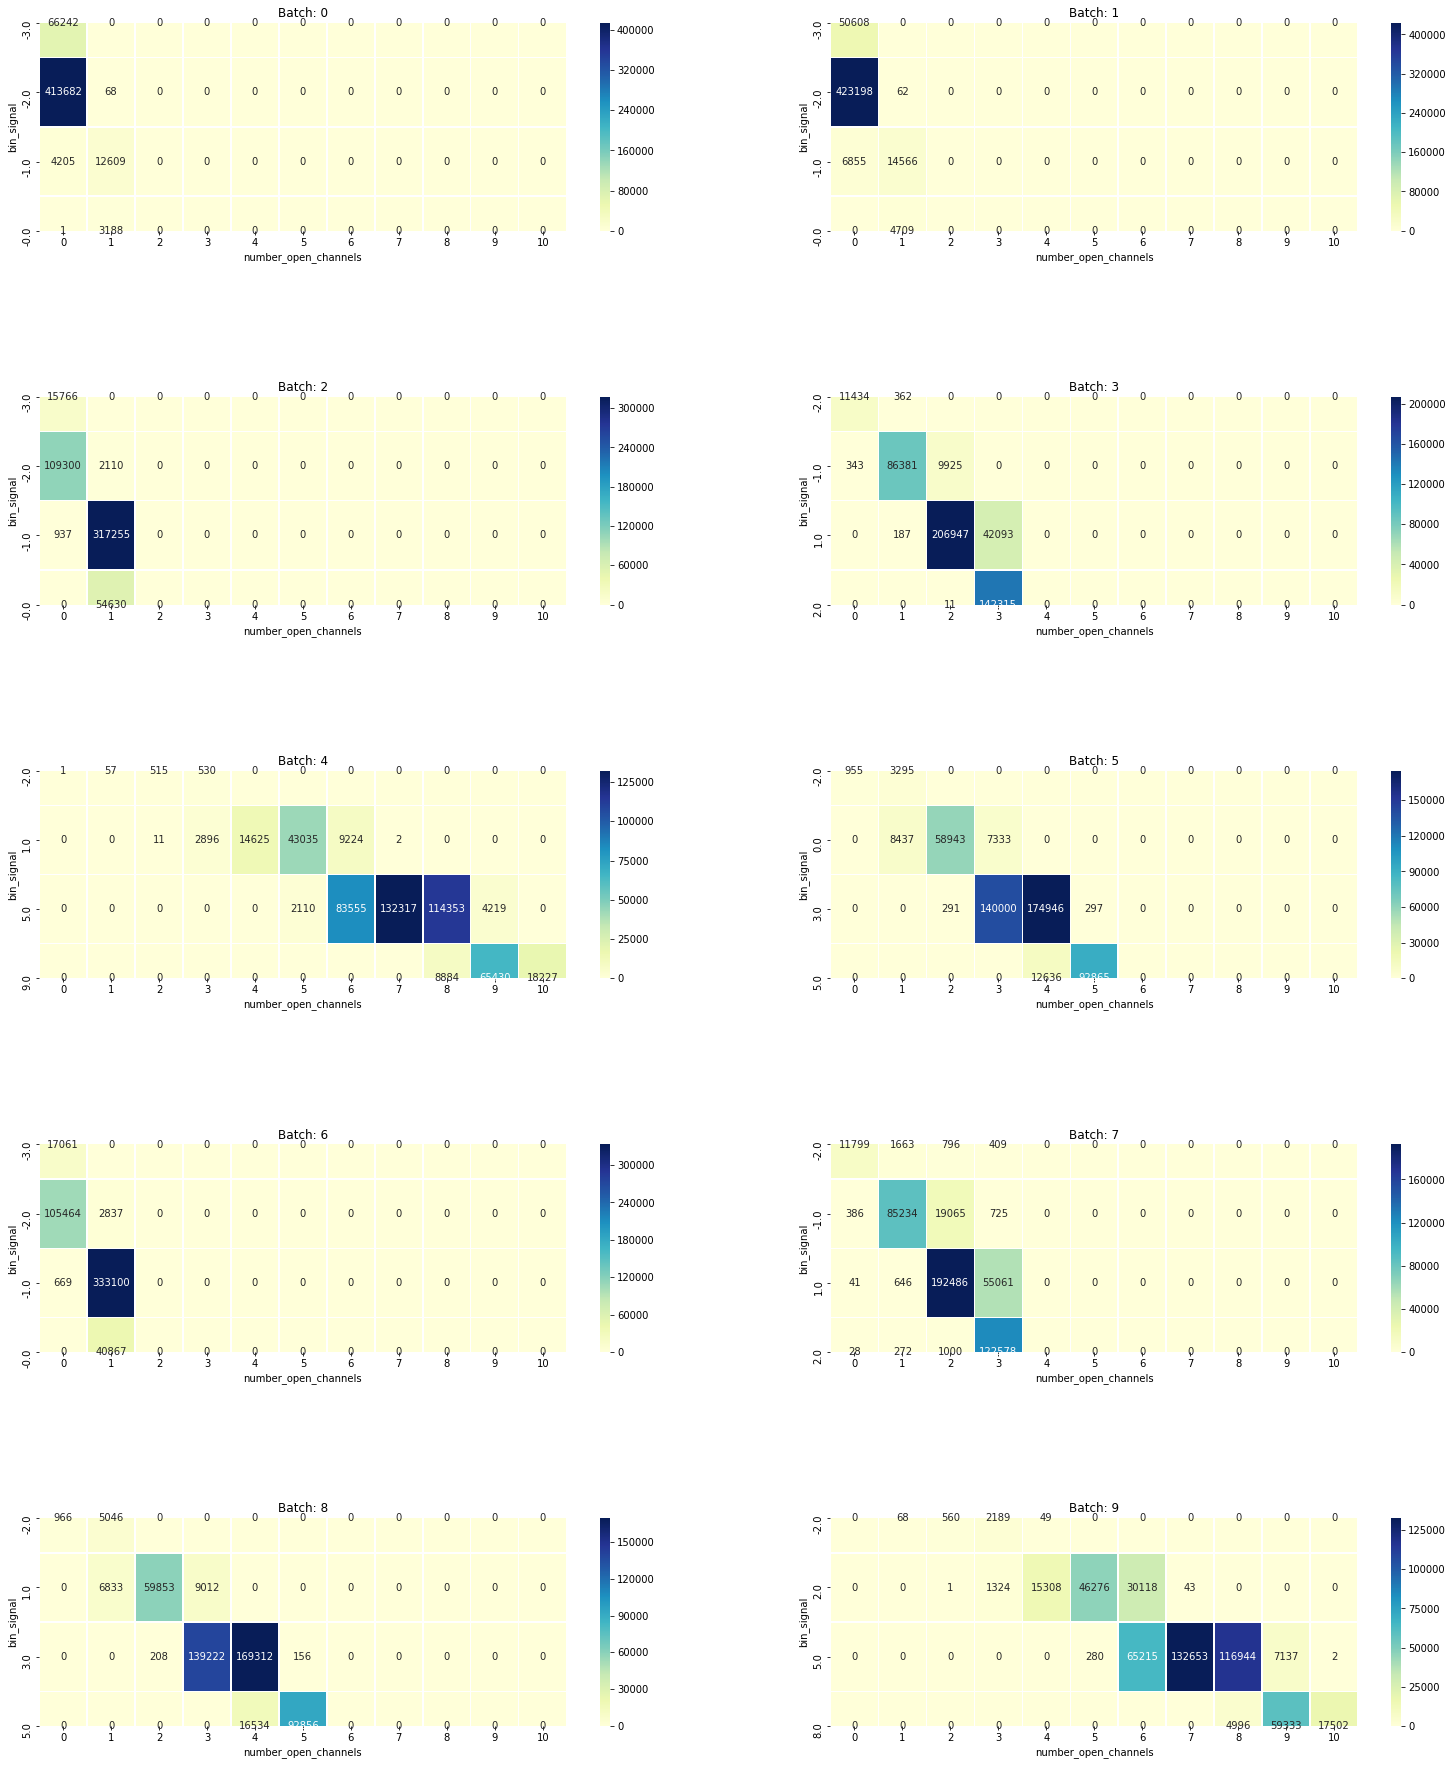

In [29]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_train['batch'].unique()):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    sns.heatmap(list_df_heatmap[i], linewidths=.5,  annot=True, fmt="d", cmap="YlGnBu")   
    plt.grid(False)

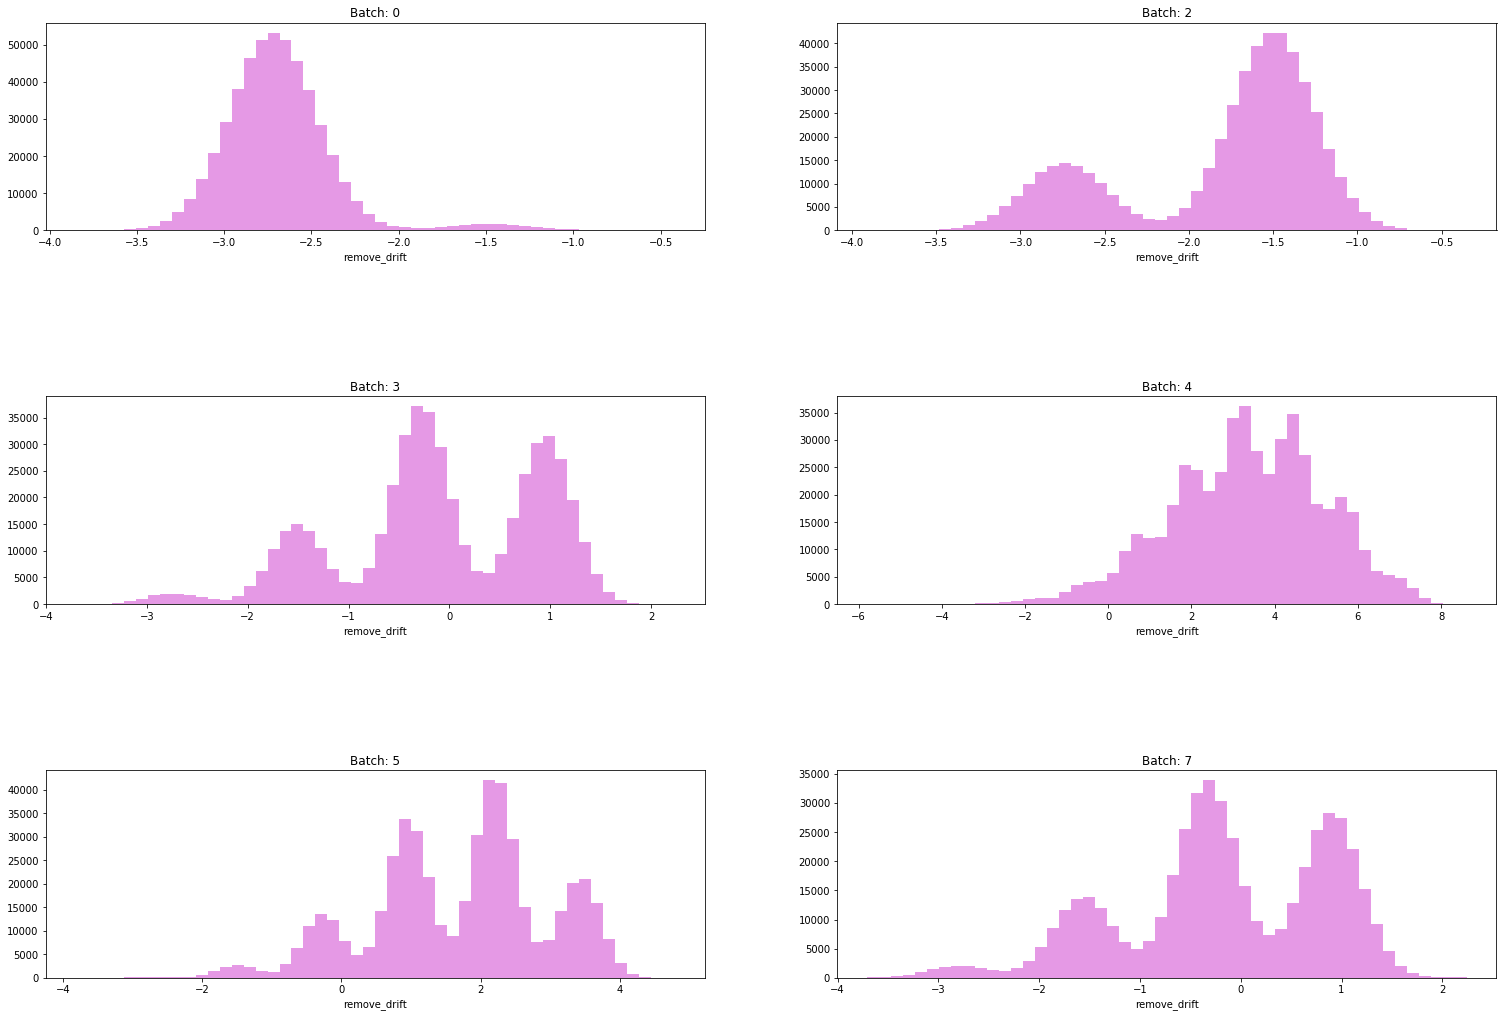

In [30]:
different_batch = [0,2,3,4,5,7]
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(different_batch):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    batch = df_train.loc[df_train['batch']==b]
    #sns.distplot(batch['open_channels'], kde=False, color="m")
    sns.distplot(batch['remove_drift'], kde=False, color="m")
    plt.grid(False)

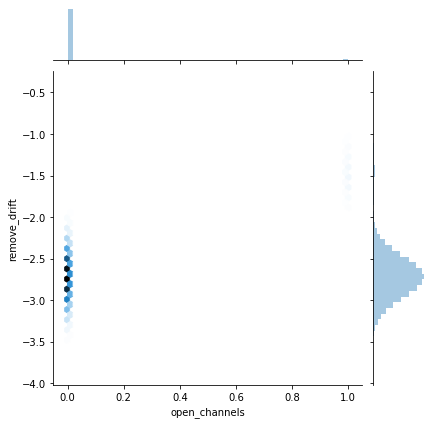

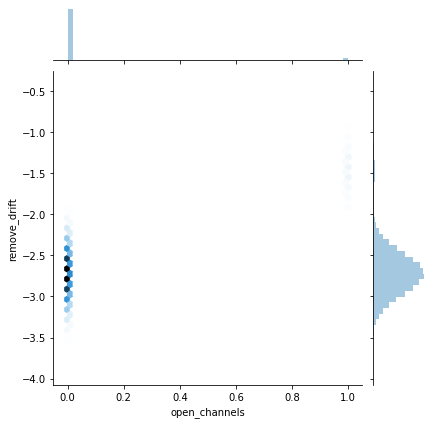

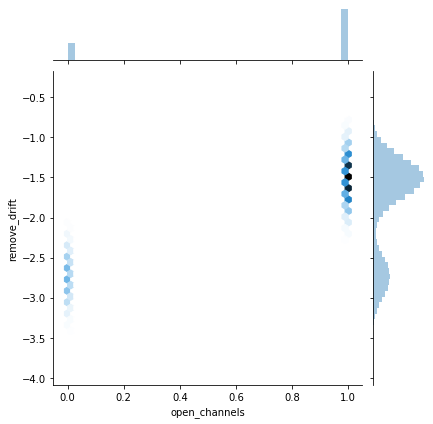

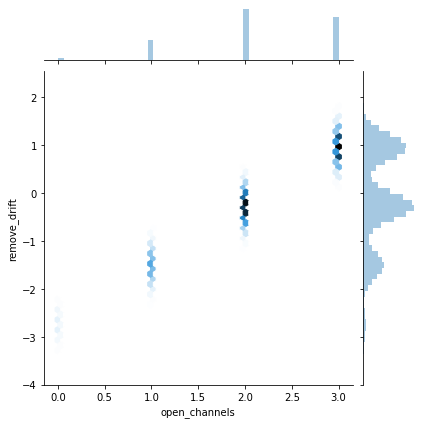

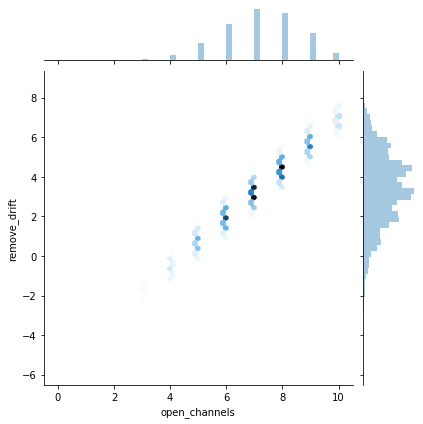

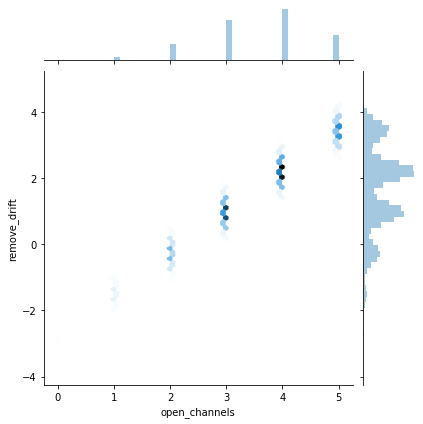

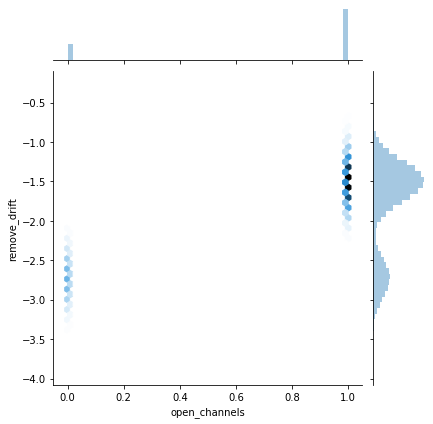

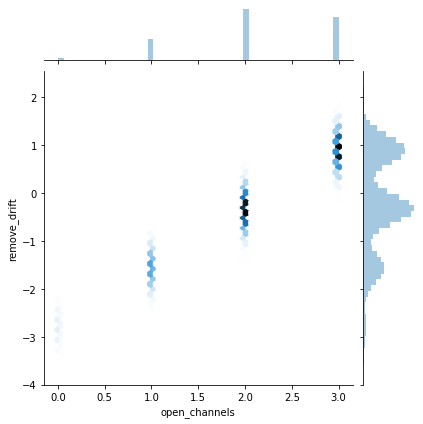

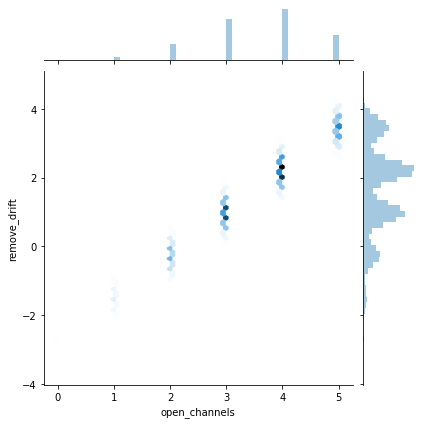

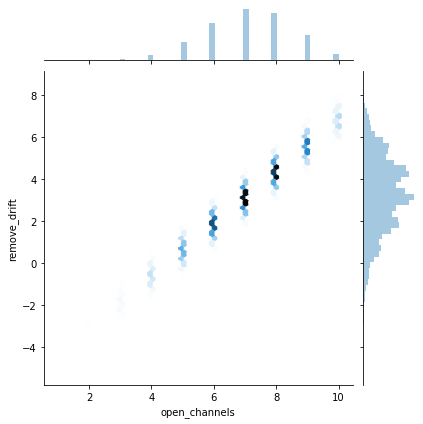

In [31]:
for b,i in zip(range(11),range(10)):
    batch = df_train.loc[df_train['batch']==b]
    sns.jointplot(batch['open_channels'], batch['remove_drift'], kind="hex")

In [32]:
info_dict = {}
info_list = []
info_open_channels = []
for b in range(10):
    batch = df_train.loc[df_train['batch']==b].copy()
    info_dict['batch'] = b
    info_dict['min_signal'] = batch['remove_drift'].min()
    info_dict['max_signal'] = batch['remove_drift'].max()
    info_dict['mean_signal'] = batch['remove_drift'].mean()
    info_open_channels.append(batch['open_channels'].value_counts().to_dict())
    info_list.append(info_dict.copy())
df_info = pd.DataFrame(info_list)
df_open_channels = pd.DataFrame(info_open_channels)
df_open_channels.fillna(0,inplace = True)
df_info = pd.concat([df_info, df_open_channels], axis = 1)

In [166]:
df_test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [167]:
print(f'Размер тестовых данных: {df_test.shape}')

Размер тестовых данных: (2000000, 2)


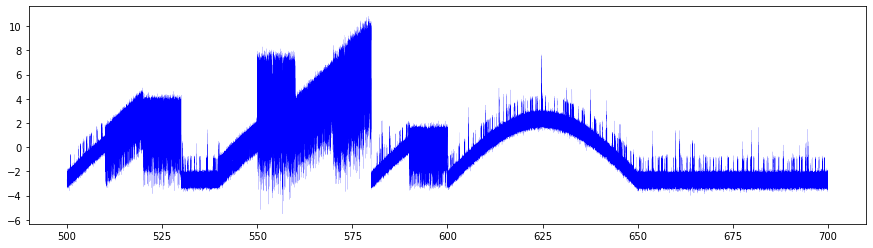

In [168]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['signal'],linewidth=.1,color='blue')

In [169]:
df_test['remove_drift'] = df_test['signal'].values

In [170]:
df_test['batch'] = df_test.index // 500000
df_test['sub_batch'] = df_test.index // 100000

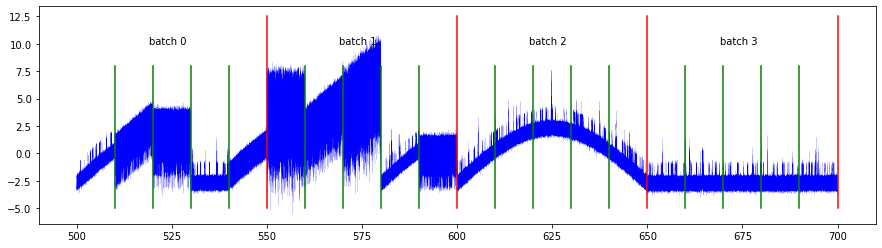

In [171]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['signal'],linewidth=.1,color='blue')

for batch in df_test['batch'].unique():
    x = float(df_test.loc[df_test['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-31,10))
    
not_plot = [4, 9, 14, 19]    
for sub_batch in df_test['sub_batch'].unique():
    boole = sub_batch in not_plot
    if not boole:
        x = float(df_test.loc[df_test['sub_batch']==sub_batch, 'time'][-1:])
        x = np.array([x,x])
        y = np.array([-5,8])
        axs.plot(x,y,color='green') 

# Sin method

In [172]:
sub_batch_drift = [0,1,4,6,7,8]
batch_drift = [2]

In [173]:
for sub_batch in sub_batch_drift:
    df_sub_batch = df_test.loc[df_test['sub_batch']==sub_batch].copy()
    popt, _ = curve_fit(my_sin, df_sub_batch['time'], df_sub_batch['signal'])
    yy = my_sin(df_sub_batch['time'],popt[0],popt[1],popt[2]) 
    
    df_test.loc[df_test['sub_batch']==sub_batch, 'remove_drift'] = (
        df_test.loc[df_test['sub_batch']==sub_batch, 'signal'] - yy) + yy.values[0]

In [174]:
df_batch = df_test.loc[df_test['batch']==2].copy()
popt, _ = curve_fit(my_sin, df_batch['time'], df_batch['signal'])
yy = my_sin(df_batch['time'],popt[0],popt[1],popt[2]) 
    
df_test.loc[df_test['batch']==2, 'remove_drift'] = (
df_test.loc[df_test['batch']==2, 'signal'] - yy) + yy.values[0]

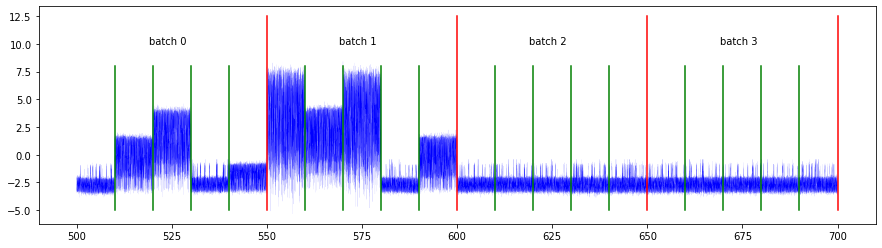

In [234]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_test['time'],df_test['remove_drift'], linewidth=.05, color='blue')

for batch in df_test['batch'].unique():
    x = float(df_test.loc[df_test['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-31,10))
    
not_plot = [4, 9, 14, 19]    
for sub_batch in df_test['sub_batch'].unique():
    boole = sub_batch in not_plot
    if not boole:
        x = float(df_test.loc[df_test['sub_batch']==sub_batch, 'time'][-1:])
        x = np.array([x,x])
        y = np.array([-5,8])
        axs.plot(x,y,color='green') 

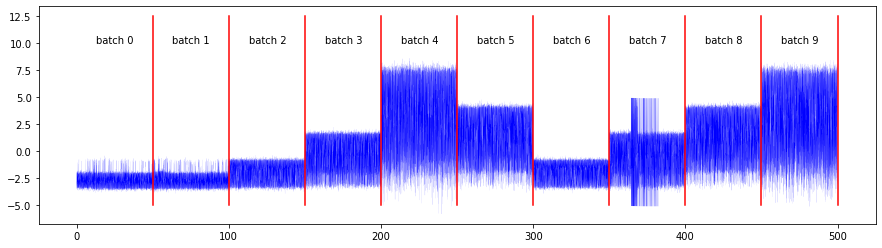

In [176]:
fig, axs = plt.subplots(figsize=(15, 4))
axs.plot(df_train['time'],df_train['remove_drift'], linewidth=.05 ,color='blue')

for batch in df_train['batch'].unique():
    x = float(df_train.loc[df_train['batch']==batch, 'time'][-1:])
    x = np.array([x,x])
    y = np.array([-5,12.5])
    axs.plot(x,y,color='red') 
    axs.annotate(f'batch {batch}', xy = (x[0]-37,10))

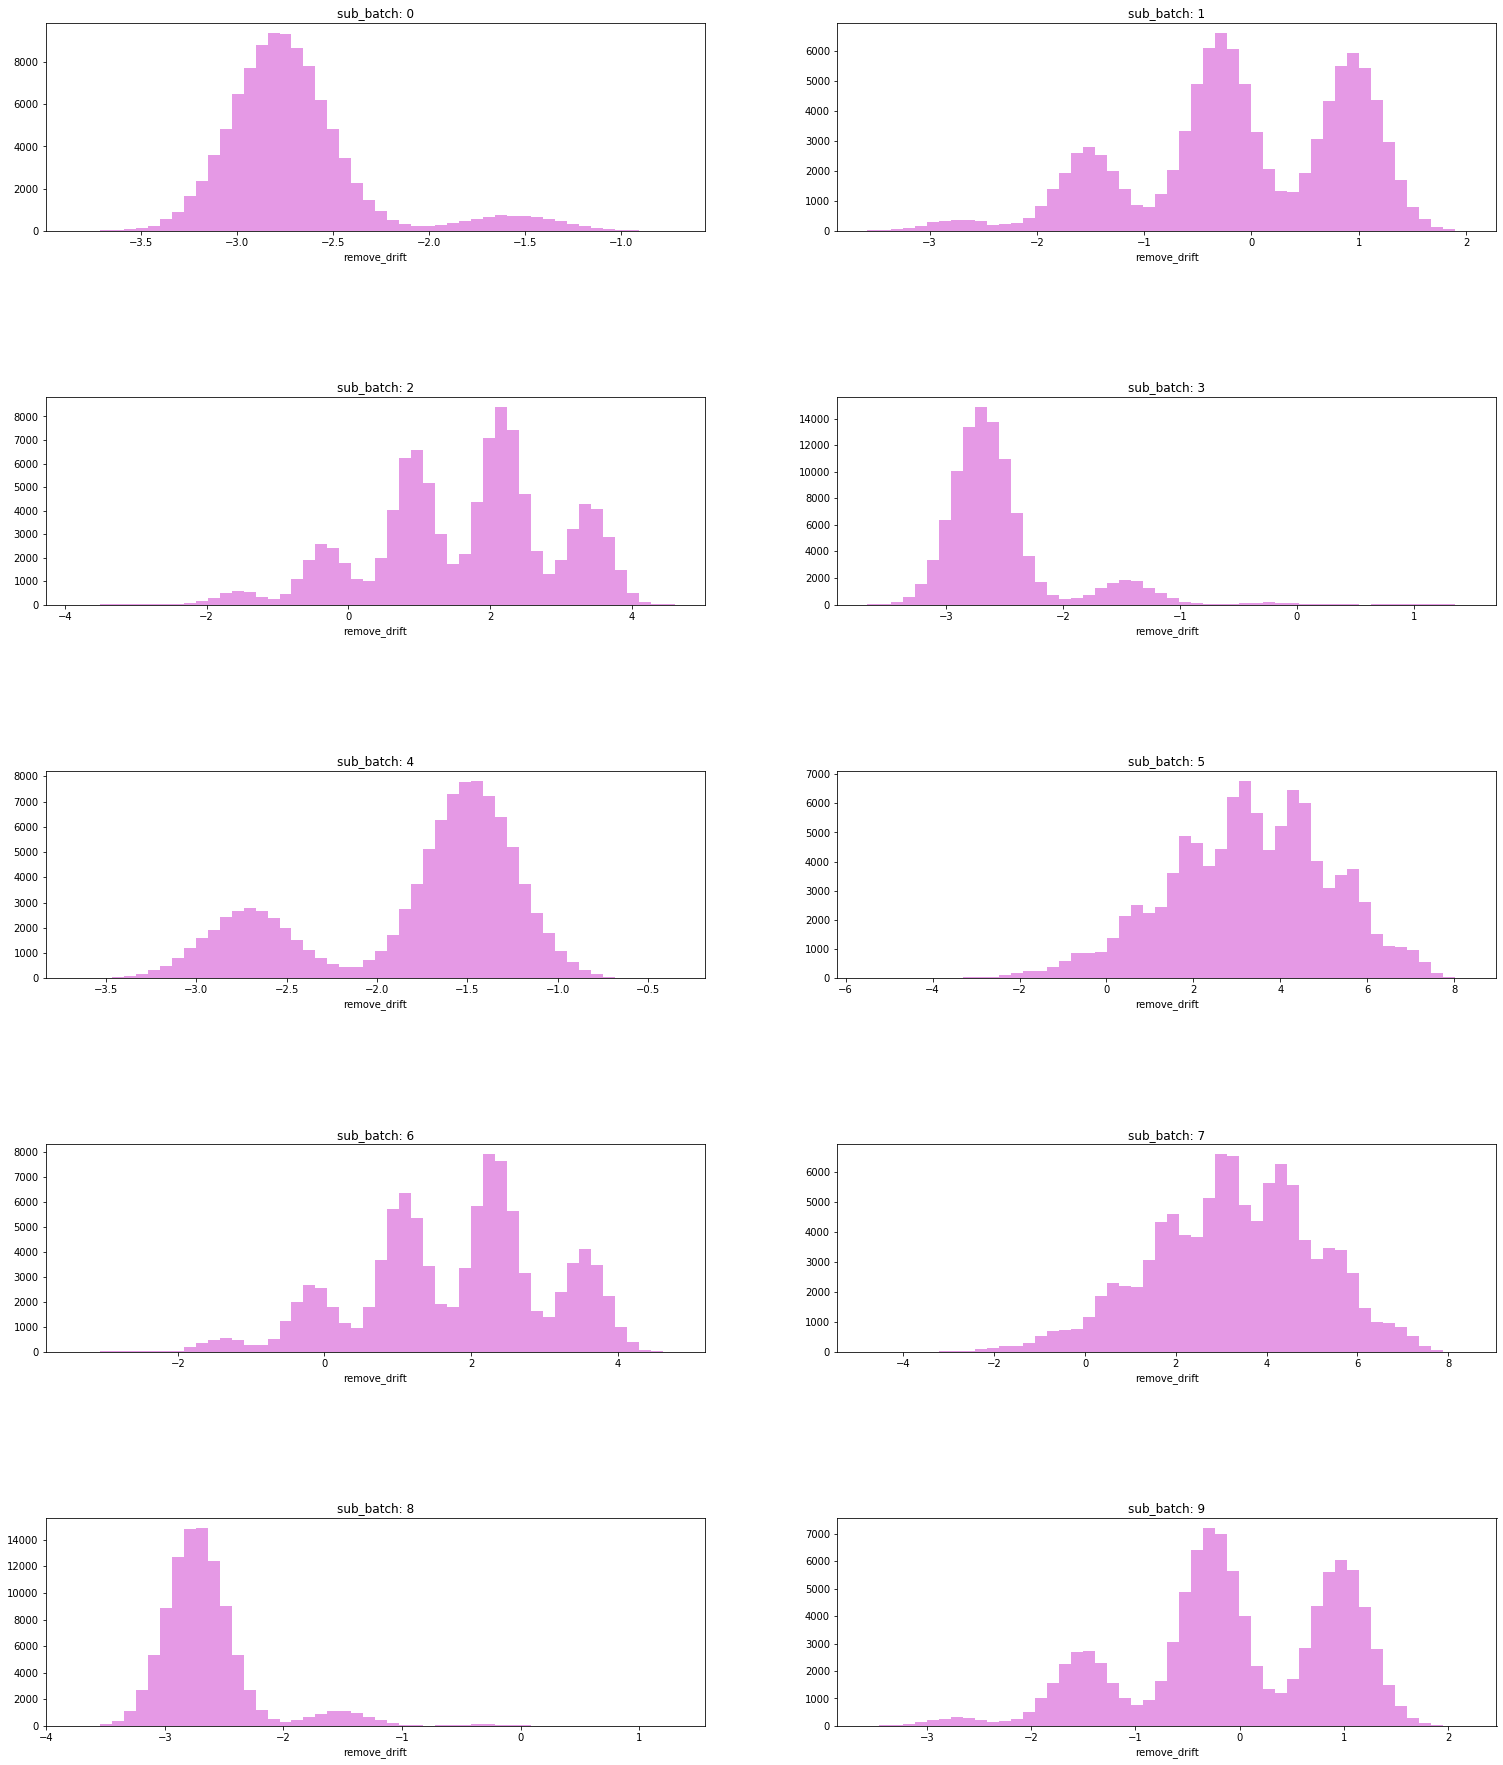

In [177]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_test['sub_batch'].unique()):
    if i<10:
        plt.subplot(5, 2, i + 1)
        plt.title(f'sub_batch: {b}')
        batch = df_test.loc[df_test['sub_batch']==b]
        #sns.distplot(batch['open_channels'], kde=False, color="m")
        sns.distplot(batch['remove_drift'], kde=False, color="m")
        plt.grid(False)

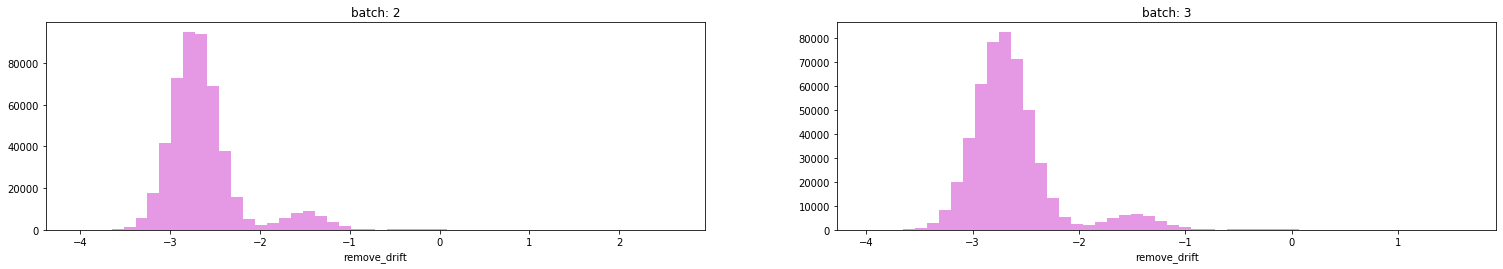

In [178]:
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(df_test['batch'].unique()):
    if i>1:
        plt.subplot(5, 2, i + 1)
        plt.title(f'batch: {b}')
        batch = df_test.loc[df_test['batch']==b]
        #sns.distplot(batch['open_channels'], kde=False, color="m")
        sns.distplot(batch['remove_drift'], kde=False, color="m")
        plt.grid(False)

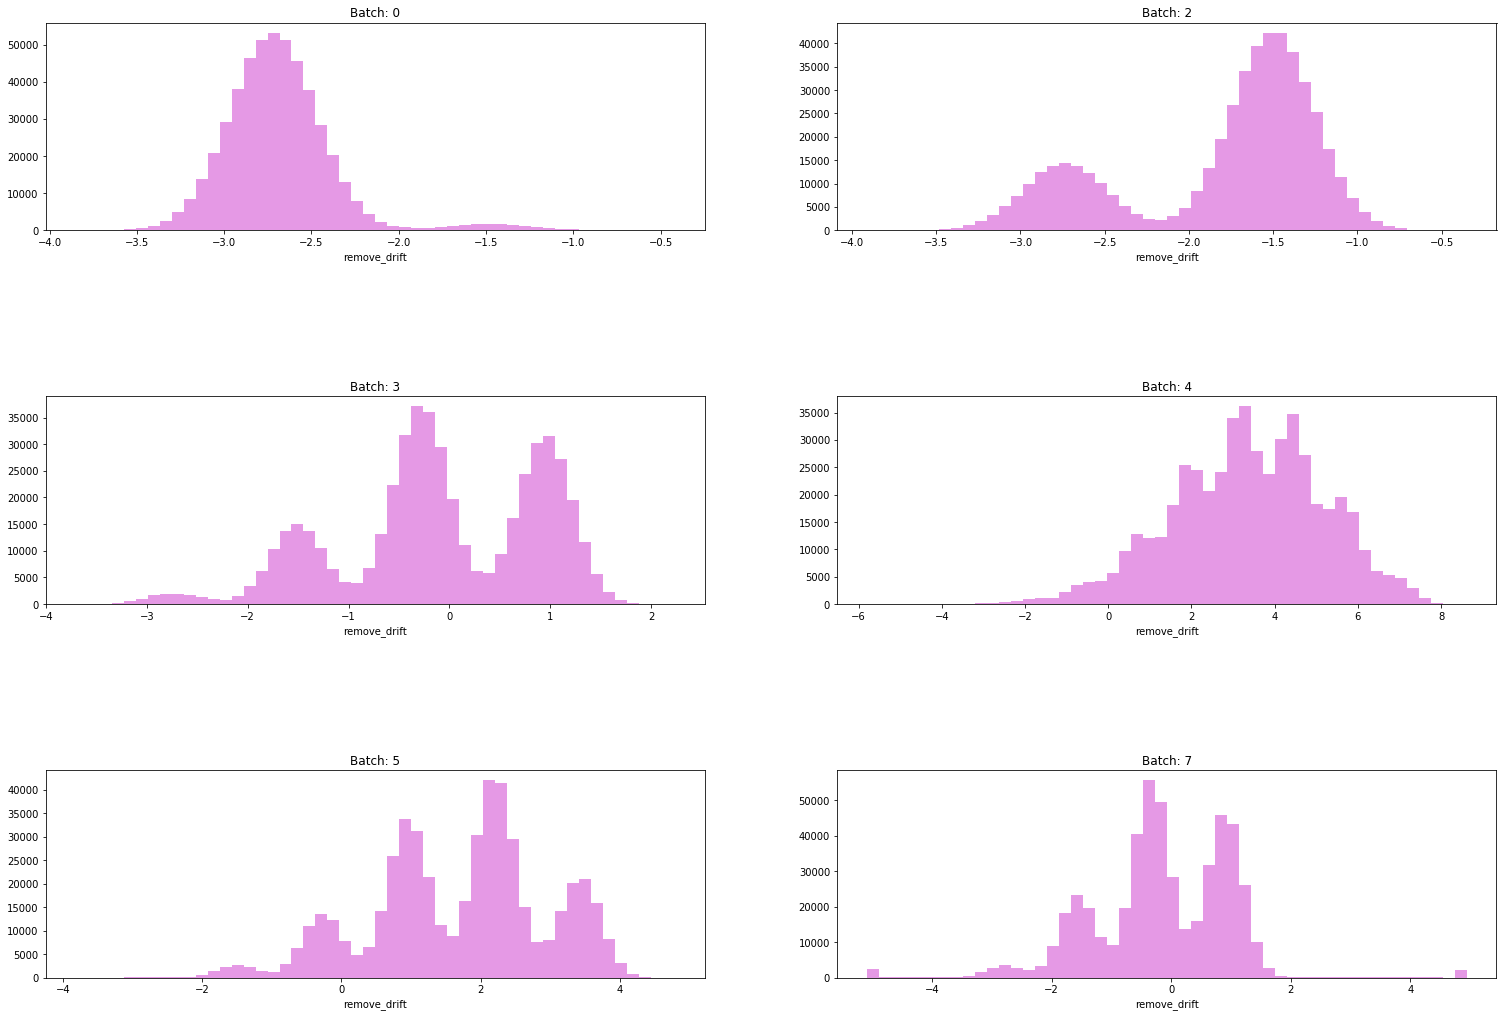

In [179]:
different_batch = [0,2,3,4,5,7]
plt.figure(figsize=(26, 22))
plt.subplots_adjust(top=1.2, hspace = 0.8)
for i, b in enumerate(different_batch):
    plt.subplot(5, 2, i + 1)
    plt.title(f'Batch: {b}')
    batch = df_train.loc[df_train['batch']==b]
    #sns.distplot(batch['open_channels'], kde=False, color="m")
    sns.distplot(batch['remove_drift'], kde=False, color="m")
    plt.grid(False)

In [180]:
sub_batch = [0,1,2,3,4,5,6,7,8,9,2,3]
batch = [0,3,5,0,2,4,5,4,0,3,0,0]
df_gen_data = pd.DataFrame(columns = ['sub_batch_test', 'batch_train'])
df_gen_data['sub_batch_test'] = sub_batch
df_gen_data['batch_train'] = batch

In [181]:
df_gen_data

,sub_batch_test,batch_train
0,0,0
1,1,3
2,2,5
3,3,0
4,4,2
5,5,4
6,6,5
7,7,4
8,8,0
9,9,3


## Features

In [182]:
#df_test.to_csv('test_preproc.csv', index = False)
#df_train.to_csv('train_preproc.csv', index = False)
df_test_clear = df_test.copy()
df_train_clear = df_train.copy()

In [253]:
#df_test = pd.read_csv('test_preproc.csv')
#df_train = pd.read_csv('test_preproc.csv')
df_test = df_test_clear.copy()
df_train = df_train_clear.copy()

In [254]:
df_test.loc[df_test['sub_batch']==7, 'remove_drift'].value_counts()

5.253676    1
5.717328    1
4.351529    1
2.640968    1
3.227184    1
           ..
5.832954    1
4.295531    1
3.329106    1
6.300167    1
3.203020    1
Name: remove_drift, Length: 100000, dtype: int64

In [255]:
df_train.loc[df_train['batch']==5, 'remove_drift'].value_counts()

 2.4998    172
 1.2498    160
 3.7498     79
 2.2011     66
 2.2705     63
          ... 
-1.7535      1
-2.5919      1
-1.8059      1
-1.8330      1
 4.2256      1
Name: remove_drift, Length: 40174, dtype: int64

In [256]:
def standard_scaler_func(df, batch = 'batch'):
    for tag_batch in df[batch].unique():
        mean = df.loc[df[batch] == tag_batch, 'remove_drift'].mean()
        std = df.loc[df[batch] == tag_batch, 'remove_drift'].std()
        df.loc[df[batch] == tag_batch, 'remove_drift'] = df.loc[df[batch] == tag_batch]['remove_drift'].transform(
    lambda x: (x-mean)/std) 

In [257]:
def add_50k_5k_batch (df):
    #add sub_batch_50k numbers
    df['sub_batch_50k'] = 0
    df['sub_batch_50k'] = df.index//50000
    #add sub_batch_5k numbers
    df['sub_batch_5k'] = 0
    df['sub_batch_5k'] = 0
    df['sub_batch_5k'] = df.index//5000

In [258]:
def batch_features_50k_5k_train(t_list):
    
    for t in t_list:   
        t['signal_batch_50k_min'] = t.groupby('sub_batch_50k')['remove_drift'].transform('min')
        t['signal_batch_50k_max'] = t.groupby('sub_batch_50k')['remove_drift'].transform('max')
        t['signal_batch_50k_std'] = t.groupby('sub_batch_50k')['remove_drift'].transform('std')
        t['signal_batch_50k_mean'] = t.groupby('sub_batch_50k')['remove_drift'].transform('mean')  
        t['mean_abs_chg_batch_50k'] = t.groupby(['sub_batch_50k'])['remove_drift'].transform(
        lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
        t['range_batch_50k'] = t['signal_batch_50k_max'] - t['signal_batch_50k_min']
        t['maxtomin_batch_50k'] = t['signal_batch_50k_max'] / t['signal_batch_50k_min']   
    
        t['signal_batch_5k_min'] = t.groupby('sub_batch_5k')['remove_drift'].transform('min')
        t['signal_batch_5k_max'] = t.groupby('sub_batch_5k')['remove_drift'].transform('max')
        t['signal_batch_5k_std'] = t.groupby('sub_batch_5k')['remove_drift'].transform('std')
        t['signal_batch_5k_mean'] = t.groupby('sub_batch_5k')['remove_drift'].transform('mean')  
        t['mean_abs_chg_batch_5k'] = t.groupby(['sub_batch_5k'])['remove_drift'].transform(
        lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
        t['range_batch_5k'] = t['signal_batch_5k_max'] - t['signal_batch_5k_min']
        t['maxtomin_batch_5k'] = t['signal_batch_5k_max'] / t['signal_batch_5k_min']
    
        t['signal_shift-2'] = t.groupby(['sub_batch_50k']).shift(-2)['remove_drift']    
        #df['flag_miss_-2'] = pd.isna(df['signal_shift-2'])
        #df['flag_miss_-2'] = np.where(df['flag_miss_-2'], 1, 0)
    
        t['signal_shift-1'] = t.groupby(['sub_batch_50k']).shift(-1)['remove_drift']
        #df['flag_miss_-1'] = pd.isna(df['signal_shift-1'])
        #df['flag_miss_-1'] = np.where(df['flag_miss_-1'], 1, 0)
      
        t['signal_shift+1'] = t.groupby(['sub_batch_50k']).shift(1)['remove_drift']
        #df['flag_miss_+1'] = pd.isna(df['signal_shift+1'])
        #df['flag_miss_+1'] = np.where(df['flag_miss_+1'], 1, 0)

        t['signal_shift+2'] = t.groupby(['sub_batch_50k']).shift(2)['remove_drift']
        #df['flag_miss_+2'] = pd.isna(df['signal_shift+2'])
        #df['flag_miss_+2'] = np.where(df['flag_miss_+2'], 1, 0)
    
    
        t.fillna(0, inplace = True)
    
        column_for_dif = ['signal_batch_50k_min','signal_batch_50k_max','signal_batch_50k_mean',
                      'signal_batch_5k_min','signal_batch_5k_max', 'signal_batch_5k_mean',
                     'signal_shift-1']
    
        for column in column_for_dif:
            t[f"{column}_dif"] = np.abs(t[column] - t['remove_drift'])

In [259]:
def batch_features_50k_5k_test(df):
    
    df['signal_batch_50k_min'] = df.groupby('sub_batch_50k')['remove_drift'].transform('min')
    df['signal_batch_50k_max'] = df.groupby('sub_batch_50k')['remove_drift'].transform('max')
    df['signal_batch_50k_std'] = df.groupby('sub_batch_50k')['remove_drift'].transform('std')
    df['signal_batch_50k_mean'] = df.groupby('sub_batch_50k')['remove_drift'].transform('mean')  
    df['mean_abs_chg_batch_50k'] = df.groupby(['sub_batch_50k'])['remove_drift'].transform(
    lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
    df['range_batch_50k'] = df['signal_batch_50k_max'] - df['signal_batch_50k_min']
    df['maxtomin_batch_50k'] = df['signal_batch_50k_max'] / df['signal_batch_50k_min']   
    
    df['signal_batch_5k_min'] = df.groupby('sub_batch_5k')['remove_drift'].transform('min')
    df['signal_batch_5k_max'] = df.groupby('sub_batch_5k')['remove_drift'].transform('max')
    df['signal_batch_5k_std'] = df.groupby('sub_batch_5k')['remove_drift'].transform('std')
    df['signal_batch_5k_mean'] = df.groupby('sub_batch_5k')['remove_drift'].transform('mean')  
    df['mean_abs_chg_batch_5k'] = df.groupby(['sub_batch_5k'])['remove_drift'].transform(
    lambda x: np.mean(np.abs(np.diff(x)))) # средняя разница между соседними значениями сигналов
    
    df['range_batch_5k'] = df['signal_batch_5k_max'] - df['signal_batch_5k_min']
    df['maxtomin_batch_5k'] = df['signal_batch_5k_max'] / df['signal_batch_5k_min']
    
    df['signal_shift-2'] = df.groupby(['sub_batch_50k']).shift(-2)['remove_drift']    
    #df['flag_miss_-2'] = pd.isna(df['signal_shift-2'])
    #df['flag_miss_-2'] = np.where(df['flag_miss_-2'], 1, 0)
    
    df['signal_shift-1'] = df.groupby(['sub_batch_50k']).shift(-1)['remove_drift']
    #df['flag_miss_-1'] = pd.isna(df['signal_shift-1'])
    #df['flag_miss_-1'] = np.where(df['flag_miss_-1'], 1, 0)
      
    df['signal_shift+1'] = df.groupby(['sub_batch_50k']).shift(1)['remove_drift']
    #df['flag_miss_+1'] = pd.isna(df['signal_shift+1'])
    #df['flag_miss_+1'] = np.where(df['flag_miss_+1'], 1, 0)

    df['signal_shift+2'] = df.groupby(['sub_batch_50k']).shift(2)['remove_drift']
    #df['flag_miss_+2'] = pd.isna(df['signal_shift+2'])
    #df['flag_miss_+2'] = np.where(df['flag_miss_+2'], 1, 0)
    
    
    df.fillna(0, inplace = True)
    
    column_for_dif = ['signal_batch_50k_min','signal_batch_50k_max','signal_batch_50k_mean',
                      'signal_batch_5k_min','signal_batch_5k_max', 'signal_batch_5k_mean',
                     'signal_shift-1']
    
    for column in column_for_dif:
        df[f"{column}_dif"] = np.abs(df[column] - df['remove_drift'])

In [55]:
'''
def quant_signal_train(t_list):
    bin_signal_list = []
    for t in t_list: 
        _, bin_signal = np.histogram(t['remove_drift'],12000)
        t['remove_drift'] = t['remove_drift'].transform(lambda x: bin_signal[np.argmin(np.abs(bin_signal-x))])
        bin_signal_list.append(bin_signal)  
    return bin_signal_list
'''

In [260]:
def quant_signal_train(df, accord_list, bin_list):
    bin_signal_list = []
    for sub_batch, bin_ in zip(accord_list, bin_list): 
        _, bin_signal = np.histogram(df.loc[df['batch'] == sub_batch, 'remove_drift'], bin_)
        df.loc[df['batch'] == sub_batch, 'remove_drift'] = df.loc[df['batch'] == sub_batch, 'remove_drift'].transform(
            lambda x: bin_signal[np.argmin(np.abs(bin_signal-x))])
        bin_signal_list.append(bin_signal)
    return bin_signal_list

In [261]:
def quant_signal_for_train(df, bin_signal_list, batch_list, accord_list):
    for sub_batch, accord in zip(batch_list, accord_list): 
        df.loc[df['batch'] == sub_batch, 'remove_drift'] = df.loc[df['batch'] == sub_batch, 'remove_drift'].transform(
            lambda x: bin_signal_list[accord][np.argmin(np.abs(bin_signal_list[accord]-x))])

In [262]:
def quant_signal_test(df, bin_signal_list, accord_list, s_batch = 'sub_batch'):
    for sub_batch, accord in zip(df[s_batch].unique(), accord_list): 
        df.loc[df[s_batch] == sub_batch, 'remove_drift'] = df.loc[df[s_batch] == sub_batch, 'remove_drift'].transform(
            lambda x: bin_signal_list[accord][np.argmin(np.abs(bin_signal_list[accord]-x))])

In [263]:
def batch_features_train(t_list): 
    for t in t_list:
        t['bin_signal'] = pd.qcut(t['remove_drift'].values, 6, labels=False)
         
        t['bin_signal_min'] = t.groupby('bin_signal')['remove_drift'].transform('min')
        t['bin_signal_max'] = t.groupby('bin_signal')['remove_drift'].transform('max')
        t['bin_signal_std'] = t.groupby('bin_signal')['remove_drift'].transform('std')
        t['bin_signal_mean'] = t.groupby('bin_signal')['remove_drift'].transform('mean') 
    
        t['range_bin_signal'] = t['bin_signal_max'] - t['bin_signal_min']
        t['maxtomin_bin_signal'] = t['bin_signal_max'] / t['bin_signal_min']
    
        column_for_dif = ['bin_signal_min','bin_signal_max','bin_signal_mean']
    
        for column in column_for_dif:
            t[f"{column}_dif"] = np.abs(t[column] - t['remove_drift'])
    
        t.drop(columns=['bin_signal_min','bin_signal_max','bin_signal_std','bin_signal_mean'], inplace=True)

In [194]:
def batch_features_test(df, batch = 'batch'): 
    for tag_batch in df[batch].unique():
        df.loc[df[batch]==tag_batch, 'bin_signal'] = pd.qcut(
             df.loc[df[batch]==tag_batch,'remove_drift'].values, 6, labels=False)
        
    for tag_batch in df[batch].unique():  
        df.loc[df[batch]==tag_batch,'bin_signal_min'] = df.loc[df[batch]==tag_batch].groupby('bin_signal')['remove_drift'].transform('min')
        df.loc[df[batch]==tag_batch,'bin_signal_max'] = df.loc[df[batch]==tag_batch].groupby('bin_signal')['remove_drift'].transform('max')
        df.loc[df[batch]==tag_batch,'bin_signal_std'] = df.loc[df[batch]==tag_batch].groupby('bin_signal')['remove_drift'].transform('std')
        df.loc[df[batch]==tag_batch,'bin_signal_mean'] = df.loc[df[batch]==tag_batch].groupby('bin_signal')['remove_drift'].transform('mean') 
    
    df['range_bin_signal'] = df['bin_signal_max'] - df['bin_signal_min']
    df['maxtomin_bin_signal'] = df['bin_signal_max'] / df['bin_signal_min']
    
    column_for_dif = ['bin_signal_min','bin_signal_max','bin_signal_mean']
    
    for column in column_for_dif:
        df[f"{column}_dif"] = np.abs(df[column] - df['remove_drift'])
    
    df.drop(columns=['bin_signal_min','bin_signal_max','bin_signal_std','bin_signal_mean'], inplace=True)

In [264]:
def rolling_window_train (t_list, win_size = [20, 50, 100, 1000, 4000]):
    for t in t_list:
        for w in win_size:
            t[f'rolling_window_mean_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/10)).mean()
            #t['flag_miss_mean'] = pd.isna(t[f'rolling_window_mean_{w}'])
            #t['flag_miss_mean'] = np.where(t['flag_miss_mean'], 1, 0)
            #t['flag_miss_mean'] = t['flag_miss_mean'].astype('int32')
            
            t[f'rolling_window_std_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/10)).std()
            #t[f'flag_miss_std_{w}'] = pd.isna(t[f'rolling_window_std_{w}'])
            #t[f'flag_miss_std_{w}'] = np.where(t[f'flag_miss_std_{w}'], 1, 0)
            #t[f'flag_miss_std_{w}'] = t[f'flag_miss_std_{w}'].astype('int32')
                        
            t[f'rolling_window_min_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/10)).min()
            #t[f'flag_miss_min_{w}'] = pd.isna(t[f'rolling_window_min_{w}'])
            #t[f'flag_miss_min_{w}'] = np.where(t[f'flag_miss_min_{w}'], 1, 0)
            #t[f'flag_miss_min_{w}'] = t[f'flag_miss_min_{w}'].astype('int32')
            
            t[f'rolling_window_max_{w}'] = t['remove_drift'].rolling(w, min_periods = round(w/10)).max()
            #t[f'flag_miss_max_{w}'] = pd.isna(t[f'rolling_window_max_{w}'])
            #t[f'flag_miss_max_{w}'] = np.where(t[f'flag_miss_max_{w}'], 1, 0)
            #t[f'flag_miss_max_{w}'] = t[f'flag_miss_max_{w}'].astype('int32')
            
            t[f'maxtomin_rolling_window_{w}'] = t[f'rolling_window_max_{w}'] / t[f'rolling_window_min_{w}']
            t[f'range_rolling_window_{w}'] = t[f'rolling_window_max_{w}'] - t[f'rolling_window_min_{w}']
            t.fillna(0, inplace = True)
            
            column_for_dif = [f'rolling_window_mean_{w}',f'rolling_window_min_{w}',f'rolling_window_max_{w}']
    
            for column in column_for_dif:
                t[f'{column}_dif'] = np.abs(t[column] - t['remove_drift'])
                #t[f'{column}_dif_abs'] = np.abs(t[column].abs() - t['remove_drift'].abs())

In [265]:
def rolling_window_test (df, s_batch = 'sub_batch', win_size = [20, 50, 100, 1000, 4000]):
    for s_b in df[s_batch].unique():
        for w in win_size:
            df.loc[df[s_batch] == s_b, f'rolling_window_mean_{w}'] = df.loc[df[s_batch] == s_b,'remove_drift'].rolling(
                w, min_periods = round(w/10)).mean()
            #df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_mean_{w}'])
            #df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = np.where(df.loc[df[s_batch] == s_b, 'flag_miss_mean'], 1, 0)
            #df.loc[df[s_batch] == s_b, 'flag_miss_mean'] = df.loc[df[s_batch] == s_b, 'flag_miss_mean'].astype('int32')
            
            df.loc[df[s_batch] == s_b, f'rolling_window_std_{w}'] = df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/10)).std()
            #df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] = pd.isna(df.loc[df[s_batch] == s_b,f'rolling_window_std_{w}'])
            #df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] = np.where( df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'], 1, 0)
            #df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'] =  df.loc[df[s_batch] == s_b, f'flag_miss_std_{w}'].astype('int32')
                        
            df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}'] =  df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/10)).min()
            #df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}'])
            #df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = np.where(df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'], 1, 0)
            #df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'] = df.loc[df[s_batch] == s_b, f'flag_miss_min_{w}'].astype('int32')
            
            df.loc[df[s_batch] == s_b, f'rolling_window_max_{w}'] = df.loc[df[s_batch] == s_b, 'remove_drift'].rolling(
                w, min_periods = round(w/10)).max()
            #df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = pd.isna(df.loc[df[s_batch] == s_b, f'rolling_window_max_{w}'])
            #df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = np.where(df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'], 1, 0)
            #df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'] = df.loc[df[s_batch] == s_b, f'flag_miss_max_{w}'].astype('int32')
            
            
            df.loc[df[s_batch] == s_b, f'maxtomin_rolling_window_{w}'] = df.loc[
                df[s_batch] == s_b, f'rolling_window_max_{w}'] / df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}']
            df.loc[df[s_batch] == s_b, f'range_rolling_window_{w}'] = df.loc[
                df[s_batch] == s_b, f'rolling_window_max_{w}'] - df.loc[df[s_batch] == s_b, f'rolling_window_min_{w}']
            
            df.loc[df[s_batch] == s_b] = df.loc[df[s_batch] == s_b].fillna(0)
            
            column_for_dif = [f'rolling_window_mean_{w}',f'rolling_window_min_{w}',f'rolling_window_max_{w}']
    
            for column in column_for_dif:
                 df.loc[df[s_batch] == s_b, f'{column}_dif'] =  np.abs(df.loc[
                     df[s_batch] == s_b, column] -  df.loc[df[s_batch] == s_b,'remove_drift'])
                 #df.loc[df[s_batch] == s_b, f'{column}_dif_abs'] =  np.abs(df.loc[
                     #df[s_batch] == s_b, column].abs() -  df.loc[df[s_batch] == s_b,'remove_drift'].abs())

In [266]:
def downcast_dtypes(df):   
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

In [267]:
add_50k_5k_batch(df_train)
add_50k_5k_batch(df_test)

In [99]:
acc_1 = [0,2,3,4,5]
bin_list = [16000, 17000, 30000, 59000, 40000]

In [100]:
bin_signal_list = quant_signal_train(df_train, acc_1, bin_list)

In [268]:
bin_signal_list = []
for batch in [0,2,3,4,5]:
    bin_signal = df_train.loc[df_train['batch'] == batch, 'remove_drift'].unique()
    bin_signal_list.append(bin_signal)

In [269]:
acc_2 = [0,1,2,3,4]
batch_list = [1,6,7,9,8]
quant_signal_for_train(df_train, bin_signal_list, batch_list, acc_2)

In [270]:
df_train_1 = pd.concat([df_train.loc[df_train['batch']==0], df_train.loc[df_train['batch']==1]])
df_train_2 = pd.concat([df_train.loc[df_train['batch']==2], df_train.loc[df_train['batch']==6]])
df_train_3 = pd.concat([df_train.loc[df_train['batch']==3], df_train.loc[df_train['batch']==7]])
df_train_4 = pd.concat([df_train.loc[df_train['batch']==4], df_train.loc[df_train['batch']==9]])
df_train_5 = pd.concat([df_train.loc[df_train['batch']==5], df_train.loc[df_train['batch']==8]])

train_list = [df_train_1, df_train_2, df_train_3, df_train_4, df_train_5]

In [64]:
#bin_signal_list = quant_signal_train(train_list)

In [271]:
batch_features_50k_5k_train(train_list)

In [272]:
batch_features_train(train_list)

In [273]:
rolling_window_train(train_list)

In [274]:
for i in range(5):
    train_list[i].drop(columns=['sub_batch_50k','sub_batch_5k'], inplace=True)

In [229]:
accord_list = [0,2,4,0,1,3,4,3,0,2,0,0,0,0,0,0,0,0,0,0]
quant_signal_test(df_test, bin_signal_list, accord_list)

In [275]:
batch_features_50k_5k_test(df_test)

In [276]:
batch_features_test(df_test)

In [277]:
rolling_window_test(df_test)

In [278]:
df_test.drop(columns=['sub_batch_50k','sub_batch_5k'], inplace=True)

In [ ]:
'''
missing_data = train_list[4].isnull()
for column in missing_data.columns.values.tolist():
    if True in missing_data[column].value_counts():
        print(column)
        print (missing_data[column].value_counts())
        print("")
'''

## Modeling

In [279]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [280]:
X = train_list[0].iloc[:, 4:].values
y = train_list[0].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)
model_1 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.03,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 5,
                            loss_function = 'CrossEntropy') 
model_1.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True)
y_pred = model_1.predict(X_test) 
print(f'f1_macro fourth cat model 1: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 0.5574054	test: 0.5557786	best: 0.5557786 (0)	total: 407ms	remaining: 4m 3s
1:	learn: 0.4493017	test: 0.4482260	best: 0.4482260 (1)	total: 788ms	remaining: 3m 55s
2:	learn: 0.3762864	test: 0.3719881	best: 0.3719881 (2)	total: 1.17s	remaining: 3m 53s
3:	learn: 0.3019953	test: 0.2978069	best: 0.2978069 (3)	total: 1.55s	remaining: 3m 51s
4:	learn: 0.2443891	test: 0.2390418	best: 0.2390418 (4)	total: 1.94s	remaining: 3m 50s
5:	learn: 0.1953130	test: 0.1901623	best: 0.1901623 (5)	total: 2.32s	remaining: 3m 50s
6:	learn: 0.1571755	test: 0.1516114	best: 0.1516114 (6)	total: 2.71s	remaining: 3m 49s
7:	learn: 0.1257221	test: 0.1205962	best: 0.1205962 (7)	total: 3.09s	remaining: 3m 48s
8:	learn: 0.1005909	test: 0.0961858	best: 0.0961858 (8)	total: 3.48s	remaining: 3m 48s
9:	learn: 0.0815443	test: 0.0773383	best: 0.0773383 (9)	total: 3.86s	remaining: 3m 47s
10:	learn: 0.0660404	test: 0.0621681	best: 0.0621681 (10)	total: 4.24s	remaining: 3m 47s
11:	learn: 0.0534131	test: 0.0499394	best:

93:	learn: 0.0011468	test: 0.0010758	best: 0.0010758 (93)	total: 35.6s	remaining: 3m 11s
94:	learn: 0.0011418	test: 0.0010729	best: 0.0010729 (94)	total: 36s	remaining: 3m 11s
95:	learn: 0.0011372	test: 0.0010715	best: 0.0010715 (95)	total: 36.4s	remaining: 3m 11s
96:	learn: 0.0011325	test: 0.0010686	best: 0.0010686 (96)	total: 36.8s	remaining: 3m 10s
97:	learn: 0.0011276	test: 0.0010667	best: 0.0010667 (97)	total: 37.1s	remaining: 3m 10s
98:	learn: 0.0011219	test: 0.0010649	best: 0.0010649 (98)	total: 37.5s	remaining: 3m 9s
99:	learn: 0.0011153	test: 0.0010636	best: 0.0010636 (99)	total: 37.9s	remaining: 3m 9s
100:	learn: 0.0011115	test: 0.0010620	best: 0.0010620 (100)	total: 38.3s	remaining: 3m 9s
101:	learn: 0.0011089	test: 0.0010600	best: 0.0010600 (101)	total: 38.6s	remaining: 3m 8s
102:	learn: 0.0011021	test: 0.0010567	best: 0.0010567 (102)	total: 39s	remaining: 3m 8s
103:	learn: 0.0010983	test: 0.0010560	best: 0.0010560 (103)	total: 39.4s	remaining: 3m 7s
104:	learn: 0.0010943	t

184:	learn: 0.0008910	test: 0.0009913	best: 0.0009913 (184)	total: 1m 9s	remaining: 2m 36s
185:	learn: 0.0008893	test: 0.0009913	best: 0.0009913 (184)	total: 1m 9s	remaining: 2m 35s
186:	learn: 0.0008871	test: 0.0009903	best: 0.0009903 (186)	total: 1m 10s	remaining: 2m 35s
187:	learn: 0.0008859	test: 0.0009902	best: 0.0009902 (187)	total: 1m 10s	remaining: 2m 34s
188:	learn: 0.0008837	test: 0.0009892	best: 0.0009892 (188)	total: 1m 11s	remaining: 2m 34s
189:	learn: 0.0008819	test: 0.0009884	best: 0.0009884 (189)	total: 1m 11s	remaining: 2m 34s
190:	learn: 0.0008800	test: 0.0009884	best: 0.0009884 (189)	total: 1m 11s	remaining: 2m 33s
191:	learn: 0.0008784	test: 0.0009876	best: 0.0009876 (191)	total: 1m 12s	remaining: 2m 33s
192:	learn: 0.0008770	test: 0.0009872	best: 0.0009872 (192)	total: 1m 12s	remaining: 2m 33s
193:	learn: 0.0008737	test: 0.0009865	best: 0.0009865 (193)	total: 1m 12s	remaining: 2m 32s
194:	learn: 0.0008716	test: 0.0009863	best: 0.0009863 (194)	total: 1m 13s	remainin

274:	learn: 0.0007479	test: 0.0009699	best: 0.0009699 (274)	total: 1m 43s	remaining: 2m 1s
275:	learn: 0.0007465	test: 0.0009699	best: 0.0009699 (275)	total: 1m 43s	remaining: 2m 1s
276:	learn: 0.0007452	test: 0.0009701	best: 0.0009699 (275)	total: 1m 43s	remaining: 2m 1s
277:	learn: 0.0007424	test: 0.0009695	best: 0.0009695 (277)	total: 1m 44s	remaining: 2m
278:	learn: 0.0007411	test: 0.0009690	best: 0.0009690 (278)	total: 1m 44s	remaining: 2m
279:	learn: 0.0007400	test: 0.0009691	best: 0.0009690 (278)	total: 1m 44s	remaining: 1m 59s
280:	learn: 0.0007392	test: 0.0009691	best: 0.0009690 (278)	total: 1m 45s	remaining: 1m 59s
281:	learn: 0.0007378	test: 0.0009689	best: 0.0009689 (281)	total: 1m 45s	remaining: 1m 59s
282:	learn: 0.0007369	test: 0.0009690	best: 0.0009689 (281)	total: 1m 46s	remaining: 1m 58s
283:	learn: 0.0007359	test: 0.0009690	best: 0.0009689 (281)	total: 1m 46s	remaining: 1m 58s
284:	learn: 0.0007345	test: 0.0009690	best: 0.0009689 (281)	total: 1m 46s	remaining: 1m 58s

364:	learn: 0.0006443	test: 0.0009607	best: 0.0009607 (364)	total: 2m 16s	remaining: 1m 27s
365:	learn: 0.0006424	test: 0.0009607	best: 0.0009607 (365)	total: 2m 16s	remaining: 1m 27s
366:	learn: 0.0006410	test: 0.0009606	best: 0.0009606 (366)	total: 2m 17s	remaining: 1m 27s
367:	learn: 0.0006401	test: 0.0009605	best: 0.0009605 (367)	total: 2m 17s	remaining: 1m 26s
368:	learn: 0.0006388	test: 0.0009600	best: 0.0009600 (368)	total: 2m 18s	remaining: 1m 26s
369:	learn: 0.0006376	test: 0.0009599	best: 0.0009599 (369)	total: 2m 18s	remaining: 1m 26s
370:	learn: 0.0006366	test: 0.0009597	best: 0.0009597 (370)	total: 2m 18s	remaining: 1m 25s
371:	learn: 0.0006359	test: 0.0009596	best: 0.0009596 (371)	total: 2m 19s	remaining: 1m 25s
372:	learn: 0.0006337	test: 0.0009591	best: 0.0009591 (372)	total: 2m 19s	remaining: 1m 24s
373:	learn: 0.0006321	test: 0.0009589	best: 0.0009589 (373)	total: 2m 19s	remaining: 1m 24s
374:	learn: 0.0006309	test: 0.0009588	best: 0.0009588 (374)	total: 2m 20s	remain

454:	learn: 0.0005520	test: 0.0009541	best: 0.0009541 (454)	total: 2m 50s	remaining: 54.2s
455:	learn: 0.0005512	test: 0.0009540	best: 0.0009540 (455)	total: 2m 50s	remaining: 53.8s
456:	learn: 0.0005505	test: 0.0009539	best: 0.0009539 (456)	total: 2m 50s	remaining: 53.4s
457:	learn: 0.0005496	test: 0.0009541	best: 0.0009539 (456)	total: 2m 51s	remaining: 53.1s
458:	learn: 0.0005492	test: 0.0009541	best: 0.0009539 (456)	total: 2m 51s	remaining: 52.7s
459:	learn: 0.0005480	test: 0.0009540	best: 0.0009539 (456)	total: 2m 51s	remaining: 52.3s
460:	learn: 0.0005473	test: 0.0009540	best: 0.0009539 (456)	total: 2m 52s	remaining: 51.9s
461:	learn: 0.0005458	test: 0.0009541	best: 0.0009539 (456)	total: 2m 52s	remaining: 51.6s
462:	learn: 0.0005447	test: 0.0009544	best: 0.0009539 (456)	total: 2m 53s	remaining: 51.2s
463:	learn: 0.0005438	test: 0.0009540	best: 0.0009539 (456)	total: 2m 53s	remaining: 50.8s
464:	learn: 0.0005424	test: 0.0009536	best: 0.0009536 (464)	total: 2m 53s	remaining: 50.4s

545:	learn: 0.0004730	test: 0.0009498	best: 0.0009496 (523)	total: 3m 24s	remaining: 20.2s
546:	learn: 0.0004725	test: 0.0009494	best: 0.0009494 (546)	total: 3m 24s	remaining: 19.9s
547:	learn: 0.0004716	test: 0.0009493	best: 0.0009493 (547)	total: 3m 25s	remaining: 19.5s
548:	learn: 0.0004709	test: 0.0009491	best: 0.0009491 (548)	total: 3m 25s	remaining: 19.1s
549:	learn: 0.0004703	test: 0.0009492	best: 0.0009491 (548)	total: 3m 26s	remaining: 18.7s
550:	learn: 0.0004697	test: 0.0009489	best: 0.0009489 (550)	total: 3m 26s	remaining: 18.4s
551:	learn: 0.0004686	test: 0.0009487	best: 0.0009487 (551)	total: 3m 26s	remaining: 18s
552:	learn: 0.0004675	test: 0.0009489	best: 0.0009487 (551)	total: 3m 27s	remaining: 17.6s
553:	learn: 0.0004667	test: 0.0009488	best: 0.0009487 (551)	total: 3m 27s	remaining: 17.2s
554:	learn: 0.0004661	test: 0.0009489	best: 0.0009487 (551)	total: 3m 27s	remaining: 16.9s
555:	learn: 0.0004657	test: 0.0009488	best: 0.0009487 (551)	total: 3m 28s	remaining: 16.5s
5

In [281]:
X = train_list[1].iloc[:, 4:].values
y = train_list[1].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)
model_2 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.03,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 5,
                            loss_function = 'CrossEntropy') 
model_2.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred = model_2.predict(X_test)
print(f'f1_macro second cat model 2: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 0.5984532	test: 0.5982033	best: 0.5982033 (0)	total: 394ms	remaining: 3m 55s
1:	learn: 0.5204239	test: 0.5198623	best: 0.5198623 (1)	total: 779ms	remaining: 3m 53s
2:	learn: 0.4483008	test: 0.4478332	best: 0.4478332 (2)	total: 1.17s	remaining: 3m 52s
3:	learn: 0.3956418	test: 0.3951556	best: 0.3951556 (3)	total: 1.55s	remaining: 3m 50s
4:	learn: 0.3422855	test: 0.3416555	best: 0.3416555 (4)	total: 1.94s	remaining: 3m 50s
5:	learn: 0.2956830	test: 0.2942716	best: 0.2942716 (5)	total: 2.32s	remaining: 3m 50s
6:	learn: 0.2559462	test: 0.2541310	best: 0.2541310 (6)	total: 2.71s	remaining: 3m 49s
7:	learn: 0.2145309	test: 0.2128360	best: 0.2128360 (7)	total: 3.1s	remaining: 3m 49s
8:	learn: 0.1873335	test: 0.1856819	best: 0.1856819 (8)	total: 3.48s	remaining: 3m 48s
9:	learn: 0.1623180	test: 0.1616088	best: 0.1616088 (9)	total: 3.87s	remaining: 3m 48s
10:	learn: 0.1387872	test: 0.1385592	best: 0.1385592 (10)	total: 4.26s	remaining: 3m 48s
11:	learn: 0.1213707	test: 0.1216281	best:

93:	learn: 0.0070865	test: 0.0076032	best: 0.0076032 (93)	total: 36.7s	remaining: 3m 17s
94:	learn: 0.0070663	test: 0.0075814	best: 0.0075814 (94)	total: 37.1s	remaining: 3m 17s
95:	learn: 0.0070527	test: 0.0075700	best: 0.0075700 (95)	total: 37.5s	remaining: 3m 16s
96:	learn: 0.0070400	test: 0.0075593	best: 0.0075593 (96)	total: 37.9s	remaining: 3m 16s
97:	learn: 0.0070233	test: 0.0075445	best: 0.0075445 (97)	total: 38.2s	remaining: 3m 15s
98:	learn: 0.0070121	test: 0.0075385	best: 0.0075385 (98)	total: 38.6s	remaining: 3m 15s
99:	learn: 0.0069860	test: 0.0075153	best: 0.0075153 (99)	total: 39s	remaining: 3m 15s
100:	learn: 0.0069747	test: 0.0075067	best: 0.0075067 (100)	total: 39.4s	remaining: 3m 14s
101:	learn: 0.0069616	test: 0.0074955	best: 0.0074955 (101)	total: 39.8s	remaining: 3m 14s
102:	learn: 0.0069431	test: 0.0074793	best: 0.0074793 (102)	total: 40.2s	remaining: 3m 13s
103:	learn: 0.0069335	test: 0.0074713	best: 0.0074713 (103)	total: 40.6s	remaining: 3m 13s
104:	learn: 0.0

184:	learn: 0.0064188	test: 0.0071487	best: 0.0071487 (184)	total: 1m 11s	remaining: 2m 40s
185:	learn: 0.0064157	test: 0.0071466	best: 0.0071466 (185)	total: 1m 11s	remaining: 2m 40s
186:	learn: 0.0064125	test: 0.0071458	best: 0.0071458 (186)	total: 1m 12s	remaining: 2m 39s
187:	learn: 0.0064080	test: 0.0071442	best: 0.0071442 (187)	total: 1m 12s	remaining: 2m 39s
188:	learn: 0.0064042	test: 0.0071421	best: 0.0071421 (188)	total: 1m 13s	remaining: 2m 38s
189:	learn: 0.0064026	test: 0.0071416	best: 0.0071416 (189)	total: 1m 13s	remaining: 2m 38s
190:	learn: 0.0063998	test: 0.0071410	best: 0.0071410 (190)	total: 1m 13s	remaining: 2m 38s
191:	learn: 0.0063954	test: 0.0071394	best: 0.0071394 (191)	total: 1m 14s	remaining: 2m 37s
192:	learn: 0.0063919	test: 0.0071379	best: 0.0071379 (192)	total: 1m 14s	remaining: 2m 37s
193:	learn: 0.0063888	test: 0.0071375	best: 0.0071375 (193)	total: 1m 14s	remaining: 2m 36s
194:	learn: 0.0063852	test: 0.0071357	best: 0.0071357 (194)	total: 1m 15s	remain

274:	learn: 0.0061222	test: 0.0070658	best: 0.0070658 (274)	total: 1m 45s	remaining: 2m 4s
275:	learn: 0.0061203	test: 0.0070662	best: 0.0070658 (274)	total: 1m 45s	remaining: 2m 4s
276:	learn: 0.0061173	test: 0.0070663	best: 0.0070658 (274)	total: 1m 46s	remaining: 2m 3s
277:	learn: 0.0061156	test: 0.0070651	best: 0.0070651 (277)	total: 1m 46s	remaining: 2m 3s
278:	learn: 0.0061140	test: 0.0070642	best: 0.0070642 (278)	total: 1m 47s	remaining: 2m 3s
279:	learn: 0.0061107	test: 0.0070633	best: 0.0070633 (279)	total: 1m 47s	remaining: 2m 2s
280:	learn: 0.0061079	test: 0.0070623	best: 0.0070623 (280)	total: 1m 47s	remaining: 2m 2s
281:	learn: 0.0061049	test: 0.0070627	best: 0.0070623 (280)	total: 1m 48s	remaining: 2m 1s
282:	learn: 0.0061028	test: 0.0070622	best: 0.0070622 (282)	total: 1m 48s	remaining: 2m 1s
283:	learn: 0.0060996	test: 0.0070609	best: 0.0070609 (283)	total: 1m 48s	remaining: 2m 1s
284:	learn: 0.0060969	test: 0.0070604	best: 0.0070604 (284)	total: 1m 49s	remaining: 2m
28

364:	learn: 0.0058888	test: 0.0070346	best: 0.0070346 (364)	total: 2m 19s	remaining: 1m 30s
365:	learn: 0.0058853	test: 0.0070352	best: 0.0070346 (364)	total: 2m 20s	remaining: 1m 29s
366:	learn: 0.0058821	test: 0.0070354	best: 0.0070346 (364)	total: 2m 20s	remaining: 1m 29s
367:	learn: 0.0058787	test: 0.0070357	best: 0.0070346 (364)	total: 2m 21s	remaining: 1m 28s
368:	learn: 0.0058759	test: 0.0070349	best: 0.0070346 (364)	total: 2m 21s	remaining: 1m 28s
369:	learn: 0.0058727	test: 0.0070345	best: 0.0070345 (369)	total: 2m 21s	remaining: 1m 28s
370:	learn: 0.0058709	test: 0.0070341	best: 0.0070341 (370)	total: 2m 22s	remaining: 1m 27s
371:	learn: 0.0058687	test: 0.0070343	best: 0.0070341 (370)	total: 2m 22s	remaining: 1m 27s
372:	learn: 0.0058654	test: 0.0070344	best: 0.0070341 (370)	total: 2m 23s	remaining: 1m 27s
373:	learn: 0.0058621	test: 0.0070345	best: 0.0070341 (370)	total: 2m 23s	remaining: 1m 26s
374:	learn: 0.0058575	test: 0.0070333	best: 0.0070333 (374)	total: 2m 23s	remain

454:	learn: 0.0056618	test: 0.0070075	best: 0.0070074 (453)	total: 2m 53s	remaining: 55.4s
455:	learn: 0.0056607	test: 0.0070070	best: 0.0070070 (455)	total: 2m 54s	remaining: 55s
456:	learn: 0.0056584	test: 0.0070070	best: 0.0070070 (456)	total: 2m 54s	remaining: 54.6s
457:	learn: 0.0056558	test: 0.0070068	best: 0.0070068 (457)	total: 2m 54s	remaining: 54.2s
458:	learn: 0.0056530	test: 0.0070067	best: 0.0070067 (458)	total: 2m 55s	remaining: 53.9s
459:	learn: 0.0056506	test: 0.0070061	best: 0.0070061 (459)	total: 2m 55s	remaining: 53.5s
460:	learn: 0.0056483	test: 0.0070060	best: 0.0070060 (460)	total: 2m 56s	remaining: 53.1s
461:	learn: 0.0056462	test: 0.0070057	best: 0.0070057 (461)	total: 2m 56s	remaining: 52.7s
462:	learn: 0.0056432	test: 0.0070055	best: 0.0070055 (462)	total: 2m 56s	remaining: 52.3s
463:	learn: 0.0056407	test: 0.0070067	best: 0.0070055 (462)	total: 2m 57s	remaining: 52s
464:	learn: 0.0056380	test: 0.0070063	best: 0.0070055 (462)	total: 2m 57s	remaining: 51.6s
465

545:	learn: 0.0054542	test: 0.0069928	best: 0.0069928 (545)	total: 3m 28s	remaining: 20.6s
546:	learn: 0.0054528	test: 0.0069921	best: 0.0069921 (546)	total: 3m 28s	remaining: 20.2s
547:	learn: 0.0054514	test: 0.0069920	best: 0.0069920 (547)	total: 3m 29s	remaining: 19.8s
548:	learn: 0.0054496	test: 0.0069914	best: 0.0069914 (548)	total: 3m 29s	remaining: 19.5s
549:	learn: 0.0054475	test: 0.0069912	best: 0.0069912 (549)	total: 3m 29s	remaining: 19.1s
550:	learn: 0.0054456	test: 0.0069915	best: 0.0069912 (549)	total: 3m 30s	remaining: 18.7s
551:	learn: 0.0054423	test: 0.0069913	best: 0.0069912 (549)	total: 3m 30s	remaining: 18.3s
552:	learn: 0.0054411	test: 0.0069911	best: 0.0069911 (552)	total: 3m 30s	remaining: 17.9s
553:	learn: 0.0054384	test: 0.0069905	best: 0.0069905 (553)	total: 3m 31s	remaining: 17.5s
554:	learn: 0.0054363	test: 0.0069906	best: 0.0069905 (553)	total: 3m 31s	remaining: 17.2s
555:	learn: 0.0054339	test: 0.0069909	best: 0.0069905 (553)	total: 3m 32s	remaining: 16.8s

In [282]:
X = train_list[2].iloc[:, 4:].values
y = train_list[2].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)
model_3 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.2,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 12,
                            loss_function = 'MultiClassOneVsAll')
model_3.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred_cat_3 = model_3.predict(X_test)
print(f'f1_macro third cat model 3: {f1_score(y_test, y_pred_cat_3, average="macro")}')

0:	learn: 0.6294966	test: 0.6294509	best: 0.6294509 (0)	total: 349ms	remaining: 3m 28s
1:	learn: 0.5873337	test: 0.5872508	best: 0.5872508 (1)	total: 691ms	remaining: 3m 26s
2:	learn: 0.4475183	test: 0.4565078	best: 0.4565078 (2)	total: 1.51s	remaining: 5m
3:	learn: 0.3510430	test: 0.3655150	best: 0.3655150 (3)	total: 2.32s	remaining: 5m 45s
4:	learn: 0.2813856	test: 0.2993928	best: 0.2993928 (4)	total: 3.12s	remaining: 6m 11s
5:	learn: 0.2288059	test: 0.2507887	best: 0.2507887 (5)	total: 3.97s	remaining: 6m 32s
6:	learn: 0.1882325	test: 0.2114498	best: 0.2114498 (6)	total: 4.82s	remaining: 6m 48s
7:	learn: 0.1562568	test: 0.1810577	best: 0.1810577 (7)	total: 5.66s	remaining: 6m 59s
8:	learn: 0.1312225	test: 0.1576326	best: 0.1576326 (8)	total: 6.5s	remaining: 7m 6s
9:	learn: 0.1116202	test: 0.1404850	best: 0.1404850 (9)	total: 7.38s	remaining: 7m 15s
10:	learn: 0.0957833	test: 0.1266680	best: 0.1266680 (10)	total: 8.25s	remaining: 7m 21s
11:	learn: 0.0826769	test: 0.1142059	best: 0.11

93:	learn: 0.0221721	test: 0.0548029	best: 0.0548029 (93)	total: 50s	remaining: 4m 29s
94:	learn: 0.0221317	test: 0.0547020	best: 0.0547020 (94)	total: 50.5s	remaining: 4m 28s
95:	learn: 0.0221213	test: 0.0547046	best: 0.0547020 (94)	total: 50.9s	remaining: 4m 27s
96:	learn: 0.0220744	test: 0.0546787	best: 0.0546787 (96)	total: 51.4s	remaining: 4m 26s
97:	learn: 0.0220527	test: 0.0546157	best: 0.0546157 (97)	total: 51.8s	remaining: 4m 25s
98:	learn: 0.0220255	test: 0.0546684	best: 0.0546157 (97)	total: 52.3s	remaining: 4m 24s
99:	learn: 0.0220020	test: 0.0546654	best: 0.0546157 (97)	total: 52.8s	remaining: 4m 24s
100:	learn: 0.0219779	test: 0.0547057	best: 0.0546157 (97)	total: 53.3s	remaining: 4m 23s
101:	learn: 0.0219409	test: 0.0547830	best: 0.0546157 (97)	total: 53.7s	remaining: 4m 22s
102:	learn: 0.0219370	test: 0.0547535	best: 0.0546157 (97)	total: 54.2s	remaining: 4m 21s
103:	learn: 0.0219317	test: 0.0547507	best: 0.0546157 (97)	total: 54.6s	remaining: 4m 20s
104:	learn: 0.02190

184:	learn: 0.0211065	test: 0.0539408	best: 0.0539356 (177)	total: 1m 30s	remaining: 3m 23s
185:	learn: 0.0211035	test: 0.0539350	best: 0.0539350 (185)	total: 1m 31s	remaining: 3m 22s
186:	learn: 0.0211002	test: 0.0539249	best: 0.0539249 (186)	total: 1m 31s	remaining: 3m 22s
187:	learn: 0.0210970	test: 0.0539180	best: 0.0539180 (187)	total: 1m 31s	remaining: 3m 21s
188:	learn: 0.0210838	test: 0.0539125	best: 0.0539125 (188)	total: 1m 32s	remaining: 3m 21s
189:	learn: 0.0210820	test: 0.0539057	best: 0.0539057 (189)	total: 1m 32s	remaining: 3m 20s
190:	learn: 0.0210749	test: 0.0539018	best: 0.0539018 (190)	total: 1m 33s	remaining: 3m 19s
191:	learn: 0.0210666	test: 0.0538716	best: 0.0538716 (191)	total: 1m 33s	remaining: 3m 19s
192:	learn: 0.0210562	test: 0.0539168	best: 0.0538716 (191)	total: 1m 34s	remaining: 3m 18s
193:	learn: 0.0210526	test: 0.0539101	best: 0.0538716 (191)	total: 1m 34s	remaining: 3m 18s
194:	learn: 0.0210468	test: 0.0538998	best: 0.0538716 (191)	total: 1m 35s	remain

274:	learn: 0.0206223	test: 0.0537507	best: 0.0537119 (226)	total: 2m 10s	remaining: 2m 33s
275:	learn: 0.0206194	test: 0.0537511	best: 0.0537119 (226)	total: 2m 10s	remaining: 2m 33s
276:	learn: 0.0206177	test: 0.0537493	best: 0.0537119 (226)	total: 2m 11s	remaining: 2m 32s
277:	learn: 0.0206154	test: 0.0537437	best: 0.0537119 (226)	total: 2m 11s	remaining: 2m 32s
278:	learn: 0.0206057	test: 0.0537063	best: 0.0537063 (278)	total: 2m 11s	remaining: 2m 31s
279:	learn: 0.0206010	test: 0.0537064	best: 0.0537063 (278)	total: 2m 12s	remaining: 2m 31s
280:	learn: 0.0205990	test: 0.0537115	best: 0.0537063 (278)	total: 2m 12s	remaining: 2m 30s
281:	learn: 0.0205917	test: 0.0536923	best: 0.0536923 (281)	total: 2m 13s	remaining: 2m 30s
282:	learn: 0.0205883	test: 0.0536951	best: 0.0536923 (281)	total: 2m 13s	remaining: 2m 29s
283:	learn: 0.0205772	test: 0.0536648	best: 0.0536648 (283)	total: 2m 14s	remaining: 2m 29s
284:	learn: 0.0205758	test: 0.0536737	best: 0.0536648 (283)	total: 2m 14s	remain

364:	learn: 0.0201750	test: 0.0535368	best: 0.0534709 (361)	total: 2m 49s	remaining: 1m 49s
365:	learn: 0.0201710	test: 0.0535471	best: 0.0534709 (361)	total: 2m 50s	remaining: 1m 48s
366:	learn: 0.0201681	test: 0.0535373	best: 0.0534709 (361)	total: 2m 50s	remaining: 1m 48s
367:	learn: 0.0201653	test: 0.0535364	best: 0.0534709 (361)	total: 2m 51s	remaining: 1m 47s
368:	learn: 0.0201644	test: 0.0535288	best: 0.0534709 (361)	total: 2m 51s	remaining: 1m 47s
369:	learn: 0.0201616	test: 0.0535148	best: 0.0534709 (361)	total: 2m 52s	remaining: 1m 46s
370:	learn: 0.0201609	test: 0.0535120	best: 0.0534709 (361)	total: 2m 52s	remaining: 1m 46s
371:	learn: 0.0201597	test: 0.0535045	best: 0.0534709 (361)	total: 2m 52s	remaining: 1m 46s
372:	learn: 0.0201568	test: 0.0535033	best: 0.0534709 (361)	total: 2m 53s	remaining: 1m 45s
373:	learn: 0.0201543	test: 0.0535075	best: 0.0534709 (361)	total: 2m 53s	remaining: 1m 45s
374:	learn: 0.0201523	test: 0.0535074	best: 0.0534709 (361)	total: 2m 54s	remain

454:	learn: 0.0198506	test: 0.0535254	best: 0.0534709 (361)	total: 3m 29s	remaining: 1m 6s
455:	learn: 0.0198484	test: 0.0535281	best: 0.0534709 (361)	total: 3m 29s	remaining: 1m 6s
456:	learn: 0.0198341	test: 0.0535747	best: 0.0534709 (361)	total: 3m 30s	remaining: 1m 5s
457:	learn: 0.0198326	test: 0.0535656	best: 0.0534709 (361)	total: 3m 30s	remaining: 1m 5s
458:	learn: 0.0198280	test: 0.0535519	best: 0.0534709 (361)	total: 3m 31s	remaining: 1m 4s
459:	learn: 0.0198252	test: 0.0535552	best: 0.0534709 (361)	total: 3m 31s	remaining: 1m 4s
460:	learn: 0.0198245	test: 0.0535499	best: 0.0534709 (361)	total: 3m 32s	remaining: 1m 3s
461:	learn: 0.0198226	test: 0.0535604	best: 0.0534709 (361)	total: 3m 32s	remaining: 1m 3s
462:	learn: 0.0198096	test: 0.0535572	best: 0.0534709 (361)	total: 3m 33s	remaining: 1m 3s
463:	learn: 0.0198078	test: 0.0535544	best: 0.0534709 (361)	total: 3m 33s	remaining: 1m 2s
464:	learn: 0.0198064	test: 0.0535444	best: 0.0534709 (361)	total: 3m 33s	remaining: 1m 2s

545:	learn: 0.0195215	test: 0.0533793	best: 0.0533441 (533)	total: 4m 9s	remaining: 24.7s
546:	learn: 0.0195205	test: 0.0533739	best: 0.0533441 (533)	total: 4m 9s	remaining: 24.2s
547:	learn: 0.0195126	test: 0.0533606	best: 0.0533441 (533)	total: 4m 10s	remaining: 23.7s
548:	learn: 0.0195116	test: 0.0533724	best: 0.0533441 (533)	total: 4m 10s	remaining: 23.3s
549:	learn: 0.0195094	test: 0.0533718	best: 0.0533441 (533)	total: 4m 11s	remaining: 22.8s
550:	learn: 0.0195078	test: 0.0533716	best: 0.0533441 (533)	total: 4m 11s	remaining: 22.4s
551:	learn: 0.0194971	test: 0.0533670	best: 0.0533441 (533)	total: 4m 12s	remaining: 21.9s
552:	learn: 0.0194948	test: 0.0533453	best: 0.0533441 (533)	total: 4m 12s	remaining: 21.5s
553:	learn: 0.0194867	test: 0.0533736	best: 0.0533441 (533)	total: 4m 12s	remaining: 21s
554:	learn: 0.0194857	test: 0.0533682	best: 0.0533441 (533)	total: 4m 13s	remaining: 20.5s
555:	learn: 0.0194842	test: 0.0533678	best: 0.0533441 (533)	total: 4m 13s	remaining: 20.1s
556

### Features level 2 for model 3

In [ ]:
X = train_list[2].iloc[:, 4:].values
y = train_list[2].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

model_3_RF = RandomForestClassifier(n_estimators = 600,
                                   max_depth = 15,
                                   random_state = 42)
model_3_RF.fit(X_train, y_train)
y_pred_RF_3 = model_3_RF.predict(X_test) 
print(f'f1_macro fifth RF model 4: {f1_score(y_test, y_pred_RF_3, average="macro")}')

In [ ]:
X = train_list[2].iloc[:, 4:].values
y = train_list[2].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

model_3_kNC = KNeighborsClassifier(n_neighbors = 11, weights = 'distance')
model_3_kNC.fit(X_train,y_train)

y_pred_kNC_3 = model_3_kNC.predict(X_test) 
print(f'f1_macro fourth kNC  model 4: {f1_score(y_test, y_pred_kNC_3, average="macro")}')

### Level 2

In [ ]:
df_level_2_cat = y_pred_cat_3
df_level_2_RF = (y_pred_RF_3).reshape(-1,1)
df_level_2_kNC = (y_pred_kNC_3).reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
df_level_2.shape

In [ ]:
df_level_2[:5,:]

In [ ]:
X = train_list[2].iloc[:, 4:].values
y = train_list[2].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

In [ ]:
y_test[:5]

In [ ]:
signal = X_test[:,:1].copy()

In [ ]:
signal[:5,:]

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2])
y_level_2 = y_test

In [ ]:
df_level_2.shape

In [ ]:
X = X_level_2
y = y_level_2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state = 42)
model_3_level_2 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 5,
                            loss_function = 'MultiClassOneVsAll') 
model_3_level_2.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred = model_3_level_2.predict(X_test) 
print(f'f1_macro fifth cat model 4 for level 2: {f1_score(y_test, y_pred, average="macro")}')

In [283]:
X = train_list[4].iloc[:, 4:].values
y = train_list[4].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)
model_5 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.2,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 9,
                            loss_function = 'MultiClassOneVsAll') 
model_5.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred = model_5.predict(X_test) 
print(f'f1_macro fifth cat model 5: {f1_score(y_test, y_pred, average="macro")}')

0:	learn: 0.5998895	test: 0.5999795	best: 0.5999795 (0)	total: 422ms	remaining: 4m 12s
1:	learn: 0.5379838	test: 0.5381486	best: 0.5381486 (1)	total: 826ms	remaining: 4m 7s
2:	learn: 0.4948118	test: 0.4950418	best: 0.4950418 (2)	total: 1.23s	remaining: 4m 4s
3:	learn: 0.4638336	test: 0.4641220	best: 0.4641220 (3)	total: 1.63s	remaining: 4m 3s
4:	learn: 0.4411961	test: 0.4415372	best: 0.4415372 (4)	total: 2.04s	remaining: 4m 2s
5:	learn: 0.4244469	test: 0.4248357	best: 0.4248357 (5)	total: 2.44s	remaining: 4m 2s
6:	learn: 0.3176591	test: 0.3176310	best: 0.3176310 (6)	total: 3.47s	remaining: 4m 54s
7:	learn: 0.3077078	test: 0.3077108	best: 0.3077108 (7)	total: 3.88s	remaining: 4m 46s
8:	learn: 0.2410140	test: 0.2408572	best: 0.2408572 (8)	total: 4.92s	remaining: 5m 23s
9:	learn: 0.1940060	test: 0.1937183	best: 0.1937183 (9)	total: 5.95s	remaining: 5m 51s
10:	learn: 0.1587942	test: 0.1584279	best: 0.1584279 (10)	total: 6.97s	remaining: 6m 13s
11:	learn: 0.1318855	test: 0.1314351	best: 0.1

121:	learn: 0.0209520	test: 0.0211230	best: 0.0211230 (121)	total: 1m 19s	remaining: 5m 11s
122:	learn: 0.0209369	test: 0.0211212	best: 0.0211212 (122)	total: 1m 20s	remaining: 5m 10s
123:	learn: 0.0209270	test: 0.0211223	best: 0.0211212 (122)	total: 1m 20s	remaining: 5m 9s
124:	learn: 0.0209159	test: 0.0211214	best: 0.0211212 (122)	total: 1m 21s	remaining: 5m 8s
125:	learn: 0.0209064	test: 0.0211197	best: 0.0211197 (125)	total: 1m 21s	remaining: 5m 7s
126:	learn: 0.0208985	test: 0.0211198	best: 0.0211197 (125)	total: 1m 22s	remaining: 5m 6s
127:	learn: 0.0208976	test: 0.0211197	best: 0.0211197 (125)	total: 1m 22s	remaining: 5m 4s
128:	learn: 0.0208956	test: 0.0211191	best: 0.0211191 (128)	total: 1m 23s	remaining: 5m 3s
129:	learn: 0.0208847	test: 0.0211139	best: 0.0211139 (129)	total: 1m 23s	remaining: 5m 3s
130:	learn: 0.0208814	test: 0.0211152	best: 0.0211139 (129)	total: 1m 24s	remaining: 5m 1s
131:	learn: 0.0208771	test: 0.0211151	best: 0.0211139 (129)	total: 1m 24s	remaining: 5m


211:	learn: 0.0203830	test: 0.0209737	best: 0.0209737 (211)	total: 2m 8s	remaining: 3m 55s
212:	learn: 0.0203805	test: 0.0209722	best: 0.0209722 (212)	total: 2m 9s	remaining: 3m 54s
213:	learn: 0.0203669	test: 0.0209656	best: 0.0209656 (213)	total: 2m 9s	remaining: 3m 53s
214:	learn: 0.0203592	test: 0.0209640	best: 0.0209640 (214)	total: 2m 10s	remaining: 3m 53s
215:	learn: 0.0203543	test: 0.0209623	best: 0.0209623 (215)	total: 2m 10s	remaining: 3m 52s
216:	learn: 0.0203531	test: 0.0209611	best: 0.0209611 (216)	total: 2m 11s	remaining: 3m 51s
217:	learn: 0.0203500	test: 0.0209611	best: 0.0209611 (216)	total: 2m 11s	remaining: 3m 51s
218:	learn: 0.0203453	test: 0.0209616	best: 0.0209611 (216)	total: 2m 12s	remaining: 3m 50s
219:	learn: 0.0203395	test: 0.0209625	best: 0.0209611 (216)	total: 2m 12s	remaining: 3m 49s
220:	learn: 0.0203286	test: 0.0209599	best: 0.0209599 (220)	total: 2m 13s	remaining: 3m 49s
221:	learn: 0.0203260	test: 0.0209586	best: 0.0209586 (221)	total: 2m 14s	remaining

301:	learn: 0.0200112	test: 0.0209342	best: 0.0209309 (297)	total: 2m 56s	remaining: 2m 54s
302:	learn: 0.0200064	test: 0.0209362	best: 0.0209309 (297)	total: 2m 57s	remaining: 2m 53s
303:	learn: 0.0200017	test: 0.0209359	best: 0.0209309 (297)	total: 2m 57s	remaining: 2m 53s
304:	learn: 0.0199981	test: 0.0209351	best: 0.0209309 (297)	total: 2m 58s	remaining: 2m 52s
305:	learn: 0.0199948	test: 0.0209350	best: 0.0209309 (297)	total: 2m 58s	remaining: 2m 51s
306:	learn: 0.0199940	test: 0.0209348	best: 0.0209309 (297)	total: 2m 59s	remaining: 2m 51s
307:	learn: 0.0199928	test: 0.0209347	best: 0.0209309 (297)	total: 2m 59s	remaining: 2m 50s
308:	learn: 0.0199897	test: 0.0209344	best: 0.0209309 (297)	total: 3m	remaining: 2m 49s
309:	learn: 0.0199877	test: 0.0209340	best: 0.0209309 (297)	total: 3m	remaining: 2m 49s
310:	learn: 0.0199838	test: 0.0209333	best: 0.0209309 (297)	total: 3m 1s	remaining: 2m 48s
311:	learn: 0.0199818	test: 0.0209333	best: 0.0209309 (297)	total: 3m 2s	remaining: 2m 48

391:	learn: 0.0196884	test: 0.0208878	best: 0.0208878 (391)	total: 3m 45s	remaining: 1m 59s
392:	learn: 0.0196855	test: 0.0208882	best: 0.0208878 (391)	total: 3m 45s	remaining: 1m 58s
393:	learn: 0.0196847	test: 0.0208879	best: 0.0208878 (391)	total: 3m 46s	remaining: 1m 58s
394:	learn: 0.0196812	test: 0.0208880	best: 0.0208878 (391)	total: 3m 46s	remaining: 1m 57s
395:	learn: 0.0196793	test: 0.0208868	best: 0.0208868 (395)	total: 3m 47s	remaining: 1m 57s
396:	learn: 0.0196743	test: 0.0208886	best: 0.0208868 (395)	total: 3m 47s	remaining: 1m 56s
397:	learn: 0.0196720	test: 0.0208885	best: 0.0208868 (395)	total: 3m 48s	remaining: 1m 55s
398:	learn: 0.0196673	test: 0.0208876	best: 0.0208868 (395)	total: 3m 48s	remaining: 1m 55s
399:	learn: 0.0196638	test: 0.0208882	best: 0.0208868 (395)	total: 3m 49s	remaining: 1m 54s
400:	learn: 0.0196552	test: 0.0208862	best: 0.0208862 (400)	total: 3m 49s	remaining: 1m 54s
401:	learn: 0.0196484	test: 0.0208861	best: 0.0208861 (401)	total: 3m 50s	remain

481:	learn: 0.0194123	test: 0.0208804	best: 0.0208771 (454)	total: 4m 33s	remaining: 1m 6s
482:	learn: 0.0194108	test: 0.0208813	best: 0.0208771 (454)	total: 4m 33s	remaining: 1m 6s
483:	learn: 0.0194098	test: 0.0208812	best: 0.0208771 (454)	total: 4m 34s	remaining: 1m 5s
484:	learn: 0.0194072	test: 0.0208809	best: 0.0208771 (454)	total: 4m 34s	remaining: 1m 5s
485:	learn: 0.0194030	test: 0.0208798	best: 0.0208771 (454)	total: 4m 35s	remaining: 1m 4s
486:	learn: 0.0194021	test: 0.0208796	best: 0.0208771 (454)	total: 4m 35s	remaining: 1m 3s
487:	learn: 0.0194015	test: 0.0208796	best: 0.0208771 (454)	total: 4m 36s	remaining: 1m 3s
488:	learn: 0.0193940	test: 0.0208787	best: 0.0208771 (454)	total: 4m 36s	remaining: 1m 2s
489:	learn: 0.0193924	test: 0.0208798	best: 0.0208771 (454)	total: 4m 37s	remaining: 1m 2s
490:	learn: 0.0193885	test: 0.0208808	best: 0.0208771 (454)	total: 4m 37s	remaining: 1m 1s
491:	learn: 0.0193820	test: 0.0208812	best: 0.0208771 (454)	total: 4m 38s	remaining: 1m 1s

572:	learn: 0.0191171	test: 0.0208562	best: 0.0208553 (529)	total: 5m 24s	remaining: 15.3s
573:	learn: 0.0191158	test: 0.0208571	best: 0.0208553 (529)	total: 5m 25s	remaining: 14.7s
574:	learn: 0.0191138	test: 0.0208560	best: 0.0208553 (529)	total: 5m 26s	remaining: 14.2s
575:	learn: 0.0191037	test: 0.0208575	best: 0.0208553 (529)	total: 5m 26s	remaining: 13.6s
576:	learn: 0.0191019	test: 0.0208571	best: 0.0208553 (529)	total: 5m 27s	remaining: 13s
577:	learn: 0.0191016	test: 0.0208568	best: 0.0208553 (529)	total: 5m 27s	remaining: 12.5s
578:	learn: 0.0190984	test: 0.0208569	best: 0.0208553 (529)	total: 5m 28s	remaining: 11.9s
579:	learn: 0.0190911	test: 0.0208478	best: 0.0208478 (579)	total: 5m 28s	remaining: 11.3s
580:	learn: 0.0190897	test: 0.0208475	best: 0.0208475 (580)	total: 5m 29s	remaining: 10.8s
581:	learn: 0.0190884	test: 0.0208479	best: 0.0208475 (580)	total: 5m 29s	remaining: 10.2s
582:	learn: 0.0190802	test: 0.0208503	best: 0.0208475 (580)	total: 5m 30s	remaining: 9.63s
5

In [284]:
X = train_list[3].iloc[:, 4:].values
y = train_list[3].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)
model_4 = CatBoostClassifier(iterations=1400, 
                           learning_rate = 0.05,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 14,
                            loss_function = 'MultiClassOneVsAll')
model_4.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred_cat = model_4.predict(X_test) 
print(f'f1_macro fourth cat model 4: {f1_score(y_test, y_pred_cat, average="macro")}')

0:	learn: 0.6586659	test: 0.6586717	best: 0.6586717 (0)	total: 586ms	remaining: 13m 39s
1:	learn: 0.6274785	test: 0.6274898	best: 0.6274898 (1)	total: 1.13s	remaining: 13m 12s
2:	learn: 0.5991590	test: 0.5991756	best: 0.5991756 (2)	total: 1.68s	remaining: 13m 2s
3:	learn: 0.5733558	test: 0.5733776	best: 0.5733776 (3)	total: 2.23s	remaining: 12m 57s
4:	learn: 0.5497755	test: 0.5498023	best: 0.5498023 (4)	total: 2.77s	remaining: 12m 53s
5:	learn: 0.5281704	test: 0.5282021	best: 0.5282021 (5)	total: 3.32s	remaining: 12m 51s
6:	learn: 0.5083295	test: 0.5083660	best: 0.5083660 (6)	total: 3.87s	remaining: 12m 49s
7:	learn: 0.4900715	test: 0.4901128	best: 0.4901128 (7)	total: 4.41s	remaining: 12m 47s
8:	learn: 0.4732396	test: 0.4732856	best: 0.4732856 (8)	total: 4.96s	remaining: 12m 46s
9:	learn: 0.4576971	test: 0.4577477	best: 0.4577477 (9)	total: 5.5s	remaining: 12m 45s
10:	learn: 0.4433241	test: 0.4433792	best: 0.4433792 (10)	total: 6.05s	remaining: 12m 44s
11:	learn: 0.4300149	test: 0.430

92:	learn: 0.0692696	test: 0.0718675	best: 0.0718675 (92)	total: 1m 33s	remaining: 21m 57s
93:	learn: 0.0684596	test: 0.0710628	best: 0.0710628 (93)	total: 1m 35s	remaining: 22m 3s
94:	learn: 0.0676563	test: 0.0702840	best: 0.0702840 (94)	total: 1m 36s	remaining: 22m 8s
95:	learn: 0.0669299	test: 0.0695884	best: 0.0695884 (95)	total: 1m 38s	remaining: 22m 13s
96:	learn: 0.0662350	test: 0.0688997	best: 0.0688997 (96)	total: 1m 39s	remaining: 22m 18s
97:	learn: 0.0656422	test: 0.0683311	best: 0.0683311 (97)	total: 1m 40s	remaining: 22m 21s
98:	learn: 0.0649809	test: 0.0676789	best: 0.0676789 (98)	total: 1m 42s	remaining: 22m 25s
99:	learn: 0.0647185	test: 0.0674398	best: 0.0674398 (99)	total: 1m 43s	remaining: 22m 25s
100:	learn: 0.0641160	test: 0.0668448	best: 0.0668448 (100)	total: 1m 44s	remaining: 22m 28s
101:	learn: 0.0635641	test: 0.0663037	best: 0.0663037 (101)	total: 1m 46s	remaining: 22m 31s
102:	learn: 0.0632136	test: 0.0659942	best: 0.0659942 (102)	total: 1m 47s	remaining: 22m

181:	learn: 0.0525848	test: 0.0559138	best: 0.0559138 (181)	total: 3m 17s	remaining: 22m 4s
182:	learn: 0.0525585	test: 0.0558913	best: 0.0558913 (182)	total: 3m 18s	remaining: 22m 3s
183:	learn: 0.0525208	test: 0.0558494	best: 0.0558494 (183)	total: 3m 20s	remaining: 22m 3s
184:	learn: 0.0524749	test: 0.0558091	best: 0.0558091 (184)	total: 3m 21s	remaining: 22m 2s
185:	learn: 0.0524330	test: 0.0557744	best: 0.0557744 (185)	total: 3m 22s	remaining: 22m 2s
186:	learn: 0.0523991	test: 0.0557334	best: 0.0557334 (186)	total: 3m 23s	remaining: 22m 2s
187:	learn: 0.0523669	test: 0.0557057	best: 0.0557057 (187)	total: 3m 24s	remaining: 22m
188:	learn: 0.0523275	test: 0.0556680	best: 0.0556680 (188)	total: 3m 26s	remaining: 22m 1s
189:	learn: 0.0523167	test: 0.0556594	best: 0.0556594 (189)	total: 3m 27s	remaining: 21m 59s
190:	learn: 0.0522655	test: 0.0556227	best: 0.0556227 (190)	total: 3m 28s	remaining: 22m
191:	learn: 0.0522460	test: 0.0556047	best: 0.0556047 (191)	total: 3m 29s	remaining: 

270:	learn: 0.0512382	test: 0.0547835	best: 0.0547835 (270)	total: 4m 46s	remaining: 19m 51s
271:	learn: 0.0512295	test: 0.0547763	best: 0.0547763 (271)	total: 4m 47s	remaining: 19m 50s
272:	learn: 0.0512260	test: 0.0547726	best: 0.0547726 (272)	total: 4m 48s	remaining: 19m 49s
273:	learn: 0.0512230	test: 0.0547708	best: 0.0547708 (273)	total: 4m 49s	remaining: 19m 47s
274:	learn: 0.0512109	test: 0.0547589	best: 0.0547589 (274)	total: 4m 49s	remaining: 19m 46s
275:	learn: 0.0512019	test: 0.0547534	best: 0.0547534 (275)	total: 4m 50s	remaining: 19m 44s
276:	learn: 0.0511963	test: 0.0547489	best: 0.0547489 (276)	total: 4m 51s	remaining: 19m 42s
277:	learn: 0.0511850	test: 0.0547334	best: 0.0547334 (277)	total: 4m 52s	remaining: 19m 42s
278:	learn: 0.0511771	test: 0.0547279	best: 0.0547279 (278)	total: 4m 53s	remaining: 19m 40s
279:	learn: 0.0511765	test: 0.0547269	best: 0.0547269 (279)	total: 4m 54s	remaining: 19m 38s
280:	learn: 0.0511698	test: 0.0547228	best: 0.0547228 (280)	total: 4m 

359:	learn: 0.0508178	test: 0.0544633	best: 0.0544633 (359)	total: 6m	remaining: 17m 22s
360:	learn: 0.0508161	test: 0.0544623	best: 0.0544623 (360)	total: 6m 1s	remaining: 17m 20s
361:	learn: 0.0508068	test: 0.0544556	best: 0.0544556 (361)	total: 6m 2s	remaining: 17m 19s
362:	learn: 0.0508032	test: 0.0544567	best: 0.0544556 (361)	total: 6m 3s	remaining: 17m 17s
363:	learn: 0.0508016	test: 0.0544542	best: 0.0544542 (363)	total: 6m 3s	remaining: 17m 15s
364:	learn: 0.0508011	test: 0.0544534	best: 0.0544534 (364)	total: 6m 4s	remaining: 17m 14s
365:	learn: 0.0507976	test: 0.0544518	best: 0.0544518 (365)	total: 6m 5s	remaining: 17m 12s
366:	learn: 0.0507926	test: 0.0544479	best: 0.0544479 (366)	total: 6m 6s	remaining: 17m 11s
367:	learn: 0.0507909	test: 0.0544461	best: 0.0544461 (367)	total: 6m 7s	remaining: 17m 9s
368:	learn: 0.0507878	test: 0.0544469	best: 0.0544461 (367)	total: 6m 7s	remaining: 17m 7s
369:	learn: 0.0507856	test: 0.0544448	best: 0.0544448 (369)	total: 6m 8s	remaining: 1

448:	learn: 0.0505889	test: 0.0543475	best: 0.0543474 (446)	total: 7m 12s	remaining: 15m 15s
449:	learn: 0.0505873	test: 0.0543469	best: 0.0543469 (449)	total: 7m 13s	remaining: 15m 14s
450:	learn: 0.0505859	test: 0.0543474	best: 0.0543469 (449)	total: 7m 13s	remaining: 15m 12s
451:	learn: 0.0505841	test: 0.0543477	best: 0.0543469 (449)	total: 7m 14s	remaining: 15m 11s
452:	learn: 0.0505782	test: 0.0543483	best: 0.0543469 (449)	total: 7m 15s	remaining: 15m 10s
453:	learn: 0.0505764	test: 0.0543469	best: 0.0543469 (453)	total: 7m 16s	remaining: 15m 9s
454:	learn: 0.0505737	test: 0.0543456	best: 0.0543456 (454)	total: 7m 17s	remaining: 15m 7s
455:	learn: 0.0505702	test: 0.0543459	best: 0.0543456 (454)	total: 7m 18s	remaining: 15m 6s
456:	learn: 0.0505692	test: 0.0543459	best: 0.0543456 (454)	total: 7m 18s	remaining: 15m 5s
457:	learn: 0.0505576	test: 0.0543543	best: 0.0543456 (454)	total: 7m 19s	remaining: 15m 4s
458:	learn: 0.0505567	test: 0.0543537	best: 0.0543456 (454)	total: 7m 20s	r

537:	learn: 0.0503912	test: 0.0543043	best: 0.0543025 (536)	total: 8m 24s	remaining: 13m 28s
538:	learn: 0.0503898	test: 0.0543048	best: 0.0543025 (536)	total: 8m 25s	remaining: 13m 27s
539:	learn: 0.0503886	test: 0.0543040	best: 0.0543025 (536)	total: 8m 26s	remaining: 13m 26s
540:	learn: 0.0503873	test: 0.0543034	best: 0.0543025 (536)	total: 8m 27s	remaining: 13m 25s
541:	learn: 0.0503865	test: 0.0543028	best: 0.0543025 (536)	total: 8m 27s	remaining: 13m 23s
542:	learn: 0.0503840	test: 0.0543026	best: 0.0543025 (536)	total: 8m 28s	remaining: 13m 22s
543:	learn: 0.0503825	test: 0.0543016	best: 0.0543016 (543)	total: 8m 29s	remaining: 13m 21s
544:	learn: 0.0503810	test: 0.0543008	best: 0.0543008 (544)	total: 8m 30s	remaining: 13m 20s
545:	learn: 0.0503799	test: 0.0543006	best: 0.0543006 (545)	total: 8m 31s	remaining: 13m 19s
546:	learn: 0.0503793	test: 0.0543011	best: 0.0543006 (545)	total: 8m 31s	remaining: 13m 18s
547:	learn: 0.0503782	test: 0.0543009	best: 0.0543006 (545)	total: 8m 

626:	learn: 0.0502552	test: 0.0542438	best: 0.0542357 (619)	total: 9m 35s	remaining: 11m 49s
627:	learn: 0.0502542	test: 0.0542436	best: 0.0542357 (619)	total: 9m 36s	remaining: 11m 48s
628:	learn: 0.0502480	test: 0.0542522	best: 0.0542357 (619)	total: 9m 37s	remaining: 11m 47s
629:	learn: 0.0502462	test: 0.0542509	best: 0.0542357 (619)	total: 9m 38s	remaining: 11m 46s
630:	learn: 0.0502457	test: 0.0542510	best: 0.0542357 (619)	total: 9m 38s	remaining: 11m 45s
631:	learn: 0.0502418	test: 0.0542519	best: 0.0542357 (619)	total: 9m 39s	remaining: 11m 44s
632:	learn: 0.0502415	test: 0.0542515	best: 0.0542357 (619)	total: 9m 40s	remaining: 11m 43s
633:	learn: 0.0502402	test: 0.0542512	best: 0.0542357 (619)	total: 9m 41s	remaining: 11m 42s
634:	learn: 0.0502393	test: 0.0542507	best: 0.0542357 (619)	total: 9m 42s	remaining: 11m 41s
635:	learn: 0.0502336	test: 0.0542406	best: 0.0542357 (619)	total: 9m 43s	remaining: 11m 40s
636:	learn: 0.0502331	test: 0.0542403	best: 0.0542357 (619)	total: 9m 

714:	learn: 0.0501159	test: 0.0542087	best: 0.0542077 (713)	total: 10m 45s	remaining: 10m 18s
715:	learn: 0.0501150	test: 0.0542091	best: 0.0542077 (713)	total: 10m 46s	remaining: 10m 18s
716:	learn: 0.0501140	test: 0.0542085	best: 0.0542077 (713)	total: 10m 47s	remaining: 10m 17s
717:	learn: 0.0501123	test: 0.0542088	best: 0.0542077 (713)	total: 10m 48s	remaining: 10m 16s
718:	learn: 0.0501114	test: 0.0542094	best: 0.0542077 (713)	total: 10m 49s	remaining: 10m 14s
719:	learn: 0.0501098	test: 0.0542109	best: 0.0542077 (713)	total: 10m 50s	remaining: 10m 13s
720:	learn: 0.0501072	test: 0.0542130	best: 0.0542077 (713)	total: 10m 50s	remaining: 10m 13s
721:	learn: 0.0501046	test: 0.0542106	best: 0.0542077 (713)	total: 10m 51s	remaining: 10m 12s
722:	learn: 0.0501033	test: 0.0542106	best: 0.0542077 (713)	total: 10m 52s	remaining: 10m 10s
723:	learn: 0.0501030	test: 0.0542107	best: 0.0542077 (713)	total: 10m 53s	remaining: 10m 9s
724:	learn: 0.0501017	test: 0.0542120	best: 0.0542077 (713)	t

803:	learn: 0.0500113	test: 0.0541762	best: 0.0541762 (803)	total: 11m 56s	remaining: 8m 50s
804:	learn: 0.0500101	test: 0.0541762	best: 0.0541762 (804)	total: 11m 56s	remaining: 8m 49s
805:	learn: 0.0500094	test: 0.0541758	best: 0.0541758 (805)	total: 11m 57s	remaining: 8m 48s
806:	learn: 0.0500090	test: 0.0541758	best: 0.0541758 (805)	total: 11m 58s	remaining: 8m 47s
807:	learn: 0.0500084	test: 0.0541758	best: 0.0541758 (805)	total: 11m 59s	remaining: 8m 46s
808:	learn: 0.0500072	test: 0.0541734	best: 0.0541734 (808)	total: 11m 59s	remaining: 8m 45s
809:	learn: 0.0500070	test: 0.0541735	best: 0.0541734 (808)	total: 12m	remaining: 8m 44s
810:	learn: 0.0500069	test: 0.0541734	best: 0.0541734 (810)	total: 12m 1s	remaining: 8m 43s
811:	learn: 0.0500042	test: 0.0541716	best: 0.0541716 (811)	total: 12m 2s	remaining: 8m 43s
812:	learn: 0.0500035	test: 0.0541712	best: 0.0541712 (812)	total: 12m 3s	remaining: 8m 42s
813:	learn: 0.0500031	test: 0.0541707	best: 0.0541707 (813)	total: 12m 3s	rem

892:	learn: 0.0499250	test: 0.0541464	best: 0.0541464 (892)	total: 13m 5s	remaining: 7m 26s
893:	learn: 0.0499247	test: 0.0541463	best: 0.0541463 (893)	total: 13m 6s	remaining: 7m 25s
894:	learn: 0.0499223	test: 0.0541475	best: 0.0541463 (893)	total: 13m 7s	remaining: 7m 24s
895:	learn: 0.0499211	test: 0.0541486	best: 0.0541463 (893)	total: 13m 8s	remaining: 7m 23s
896:	learn: 0.0499208	test: 0.0541489	best: 0.0541463 (893)	total: 13m 8s	remaining: 7m 22s
897:	learn: 0.0499205	test: 0.0541486	best: 0.0541463 (893)	total: 13m 9s	remaining: 7m 21s
898:	learn: 0.0499200	test: 0.0541489	best: 0.0541463 (893)	total: 13m 10s	remaining: 7m 20s
899:	learn: 0.0499178	test: 0.0541458	best: 0.0541458 (899)	total: 13m 11s	remaining: 7m 19s
900:	learn: 0.0499174	test: 0.0541455	best: 0.0541455 (900)	total: 13m 12s	remaining: 7m 18s
901:	learn: 0.0499167	test: 0.0541451	best: 0.0541451 (901)	total: 13m 12s	remaining: 7m 17s
902:	learn: 0.0499163	test: 0.0541450	best: 0.0541450 (902)	total: 13m 13s	r

981:	learn: 0.0498380	test: 0.0541213	best: 0.0541210 (973)	total: 14m 15s	remaining: 6m 4s
982:	learn: 0.0498368	test: 0.0541207	best: 0.0541207 (982)	total: 14m 16s	remaining: 6m 3s
983:	learn: 0.0498355	test: 0.0541193	best: 0.0541193 (983)	total: 14m 17s	remaining: 6m 2s
984:	learn: 0.0498349	test: 0.0541182	best: 0.0541182 (984)	total: 14m 18s	remaining: 6m 1s
985:	learn: 0.0498344	test: 0.0541180	best: 0.0541180 (985)	total: 14m 19s	remaining: 6m
986:	learn: 0.0498330	test: 0.0541187	best: 0.0541180 (985)	total: 14m 19s	remaining: 5m 59s
987:	learn: 0.0498315	test: 0.0541182	best: 0.0541180 (985)	total: 14m 20s	remaining: 5m 59s
988:	learn: 0.0498312	test: 0.0541176	best: 0.0541176 (988)	total: 14m 21s	remaining: 5m 58s
989:	learn: 0.0498304	test: 0.0541187	best: 0.0541176 (988)	total: 14m 22s	remaining: 5m 57s
990:	learn: 0.0498300	test: 0.0541186	best: 0.0541176 (988)	total: 14m 23s	remaining: 5m 56s
991:	learn: 0.0498296	test: 0.0541188	best: 0.0541176 (988)	total: 14m 23s	rem

1069:	learn: 0.0497660	test: 0.0540961	best: 0.0540961 (1069)	total: 15m 25s	remaining: 4m 45s
1070:	learn: 0.0497651	test: 0.0540963	best: 0.0540961 (1069)	total: 15m 26s	remaining: 4m 44s
1071:	learn: 0.0497640	test: 0.0540960	best: 0.0540960 (1071)	total: 15m 27s	remaining: 4m 43s
1072:	learn: 0.0497638	test: 0.0540958	best: 0.0540958 (1072)	total: 15m 28s	remaining: 4m 42s
1073:	learn: 0.0497631	test: 0.0540958	best: 0.0540958 (1072)	total: 15m 28s	remaining: 4m 41s
1074:	learn: 0.0497617	test: 0.0540979	best: 0.0540958 (1072)	total: 15m 29s	remaining: 4m 41s
1075:	learn: 0.0497608	test: 0.0540978	best: 0.0540958 (1072)	total: 15m 30s	remaining: 4m 40s
1076:	learn: 0.0497594	test: 0.0540986	best: 0.0540958 (1072)	total: 15m 31s	remaining: 4m 39s
1077:	learn: 0.0497565	test: 0.0540974	best: 0.0540958 (1072)	total: 15m 32s	remaining: 4m 38s
1078:	learn: 0.0497562	test: 0.0540976	best: 0.0540958 (1072)	total: 15m 32s	remaining: 4m 37s
1079:	learn: 0.0497550	test: 0.0540967	best: 0.054

1156:	learn: 0.0496930	test: 0.0540738	best: 0.0540734 (1155)	total: 16m 32s	remaining: 3m 28s
1157:	learn: 0.0496928	test: 0.0540736	best: 0.0540734 (1155)	total: 16m 33s	remaining: 3m 27s
1158:	learn: 0.0496917	test: 0.0540733	best: 0.0540733 (1158)	total: 16m 34s	remaining: 3m 26s
1159:	learn: 0.0496909	test: 0.0540739	best: 0.0540733 (1158)	total: 16m 34s	remaining: 3m 25s
1160:	learn: 0.0496904	test: 0.0540739	best: 0.0540733 (1158)	total: 16m 35s	remaining: 3m 24s
1161:	learn: 0.0496898	test: 0.0540738	best: 0.0540733 (1158)	total: 16m 36s	remaining: 3m 24s
1162:	learn: 0.0496894	test: 0.0540752	best: 0.0540733 (1158)	total: 16m 37s	remaining: 3m 23s
1163:	learn: 0.0496888	test: 0.0540752	best: 0.0540733 (1158)	total: 16m 37s	remaining: 3m 22s
1164:	learn: 0.0496881	test: 0.0540752	best: 0.0540733 (1158)	total: 16m 38s	remaining: 3m 21s
1165:	learn: 0.0496852	test: 0.0540765	best: 0.0540733 (1158)	total: 16m 39s	remaining: 3m 20s
1166:	learn: 0.0496840	test: 0.0540767	best: 0.054

1243:	learn: 0.0496311	test: 0.0540637	best: 0.0540621 (1209)	total: 17m 39s	remaining: 2m 12s
1244:	learn: 0.0496303	test: 0.0540645	best: 0.0540621 (1209)	total: 17m 40s	remaining: 2m 12s
1245:	learn: 0.0496295	test: 0.0540645	best: 0.0540621 (1209)	total: 17m 41s	remaining: 2m 11s
1246:	learn: 0.0496275	test: 0.0540643	best: 0.0540621 (1209)	total: 17m 42s	remaining: 2m 10s
1247:	learn: 0.0496268	test: 0.0540641	best: 0.0540621 (1209)	total: 17m 42s	remaining: 2m 9s
1248:	learn: 0.0496259	test: 0.0540639	best: 0.0540621 (1209)	total: 17m 43s	remaining: 2m 8s
1249:	learn: 0.0496253	test: 0.0540639	best: 0.0540621 (1209)	total: 17m 44s	remaining: 2m 7s
1250:	learn: 0.0496244	test: 0.0540636	best: 0.0540621 (1209)	total: 17m 45s	remaining: 2m 6s
1251:	learn: 0.0496233	test: 0.0540644	best: 0.0540621 (1209)	total: 17m 45s	remaining: 2m 5s
1252:	learn: 0.0496226	test: 0.0540646	best: 0.0540621 (1209)	total: 17m 46s	remaining: 2m 5s
1253:	learn: 0.0496211	test: 0.0540646	best: 0.0540621 (

1330:	learn: 0.0495616	test: 0.0540648	best: 0.0540581 (1303)	total: 18m 46s	remaining: 58.4s
1331:	learn: 0.0495609	test: 0.0540648	best: 0.0540581 (1303)	total: 18m 47s	remaining: 57.6s
1332:	learn: 0.0495597	test: 0.0540637	best: 0.0540581 (1303)	total: 18m 48s	remaining: 56.7s
1333:	learn: 0.0495593	test: 0.0540633	best: 0.0540581 (1303)	total: 18m 49s	remaining: 55.9s
1334:	learn: 0.0495583	test: 0.0540620	best: 0.0540581 (1303)	total: 18m 49s	remaining: 55s
1335:	learn: 0.0495575	test: 0.0540622	best: 0.0540581 (1303)	total: 18m 50s	remaining: 54.2s
1336:	learn: 0.0495570	test: 0.0540626	best: 0.0540581 (1303)	total: 18m 51s	remaining: 53.3s
1337:	learn: 0.0495566	test: 0.0540627	best: 0.0540581 (1303)	total: 18m 52s	remaining: 52.5s
1338:	learn: 0.0495558	test: 0.0540628	best: 0.0540581 (1303)	total: 18m 53s	remaining: 51.6s
1339:	learn: 0.0495554	test: 0.0540628	best: 0.0540581 (1303)	total: 18m 53s	remaining: 50.8s
1340:	learn: 0.0495552	test: 0.0540628	best: 0.0540581 (1303)	

### Features level 2 for model 4

In [ ]:
X = train_list[3].iloc[:, 4:].values
y = train_list[3].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

model_4_RF = RandomForestClassifier(n_estimators = 600,
                                   max_depth = 15,
                                   random_state = 42)
model_4_RF.fit(X_train, y_train)
y_pred_RF = model_4_RF.predict(X_test) 
print(f'f1_macro fifth RF model 4: {f1_score(y_test, y_pred_RF, average="macro")}')

In [ ]:
X = train_list[3].iloc[:, 4:].values
y = train_list[3].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

model_4_kNC = KNeighborsClassifier(n_neighbors = 11, weights = 'distance')
model_4_kNC.fit(X_train,y_train)

y_pred_kNC = model_4_kNC.predict(X_test) 
print(f'f1_macro fourth kNC  model 4: {f1_score(y_test, y_pred_kNC, average="macro")}')

## Level 2

In [ ]:
df_level_2_cat = y_pred_cat
df_level_2_RF = (y_pred_RF).reshape(-1,1)
df_level_2_kNC = y_pred_kNC.reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
df_level_2[:5,:]

In [ ]:
X = train_list[3].iloc[:, 4:].values
y = train_list[3].iloc[:, 2:3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = False)

In [ ]:
signal = X_test[:,:1].copy()

In [ ]:
signal[:5,:]

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2])
y_level_2 = y_test

In [ ]:
X_level_2.shape

In [ ]:
X = X_level_2
y = y_level_2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state = 42)
model_4_level_2 = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.02,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 5,
                            loss_function = 'MultiClassOneVsAll') 
model_4_level_2.fit(X_train, y_train, eval_set = (X_test,y_test), use_best_model = True) 
y_pred = model_4_level_2.predict(X_test) 
print(f'f1_macro fifth cat model 4 for level 2: {f1_score(y_test, y_pred, average="macro")}')

In [ ]:
X = X_level_2
y = y_level_2

kf = KFold(n_splits=5, random_state=42, shuffle=True)

model_4_level_2_cv = CatBoostClassifier(iterations=600, 
                           learning_rate = 0.02,
                           bootstrap_type = 'Bernoulli',
                           subsample = 0.4,
                           grow_policy = 'Lossguide',
                           max_leaves = 40,
                           depth = 5,
                            loss_function = 'MultiClassOneVsAll')

model_4_level_2_cv_all = cross_validate(model_4_level_2_cv, X, y, scoring='f1_macro', return_estimator=True, cv=kf)

In [ ]:
model_4_level_2_cv_all

In [ ]:
model_4_level_2_cv_final = model_4_level_2_cv_all['estimator'][2]

joblib.dump(model_1, 'model_1.pkl')  
joblib.dump(model_2, 'model_2.pkl')  
joblib.dump(model_3, 'model_3.pkl')  
joblib.dump(model_4, 'model_4.pkl')  
joblib.dump(model_5, 'model_5.pkl')  
joblib.dump(model_4_RF, 'model_4_RF.pkl')  
joblib.dump(model_4_kNC, 'model_4_kNC.pkl')   
joblib.dump(model_3_RF, 'model_3_RF.pkl')   
joblib.dump(model_3_kNC, 'model_3_kNC.pkl')   

# Этап загрузки моделей

model_1 = joblib.load('model_1.pkl')  
model_2 = joblib.load('model_2.pkl')  
model_3 = joblib.load('model_3.pkl')  
model_4 = joblib.load('model_4.pkl')  
model_5 = joblib.load('model_5.pkl')  

In [285]:
col = df_test.columns.to_list()

In [286]:
col = col[:3] + col[5:] + col[3:5]

In [287]:
df_test = df_test[col]

In [288]:
sub_batch = [0,1,2,3,4,5,6,7,8,9,2,3]
batch = [0,3,5,0,2,4,5,4,0,3,0,0]
df_gen_data = pd.DataFrame(columns = ['sub_batch_test', 'batch_train'])
df_gen_data['sub_batch_test'] = sub_batch
df_gen_data['batch_train'] = batch

In [289]:
model = np.array([1,3,5,1,2,4,5,4,1,3,1,1])
df_gen_data['model'] = model

model_list = [model_1, model_3, model_5, model_1, model_2, 
              model_4, model_5, model_4, model_1, model_3]

In [290]:
open_channels_list =[]
X_test_list = []
for sub_batch, model in zip(range(10),model_list):
    df_test_batch = df_test.loc[df_test['sub_batch']==sub_batch]
    X = df_test_batch.iloc[:, 2:-2].values
    print(X.shape)
    
    if sub_batch in [5,7]:
        X_test_list.append(X[:,:1])

    open_channels = model.predict(X)
    open_channels_list.append(open_channels)

(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)
(100000, 77)


In [139]:
y_pred_RF_test_list = []
y_pred_KNC_test_list = []

for sub_batch in [5, 7]:
    df_test_batch = df_test.loc[df_test['sub_batch']==sub_batch]
    X = df_test_batch.iloc[:, 2:-2].values
    y_pred_RF_test = model_4_RF.predict(X)
    y_pred_RF_test_list.append(y_pred_RF_test)
    y_pred_KNC_test = model_4_kNC.predict(X)
    y_pred_KNC_test_list.append(y_pred_KNC_test)

NameError: name 'model_4_RF' is not defined

In [ ]:
y_pred_cat_test_list = []
y_pred_cat_test_list.append(open_channels_list[5].copy())
y_pred_cat_test_list.append(open_channels_list[7].copy())

In [ ]:
df_level_2_cat = y_pred_cat_test_list[0].copy()
df_level_2_RF = (y_pred_RF_test_list[0].copy()).reshape(-1,1)
df_level_2_kNC = (y_pred_KNC_test_list[0].copy()).reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
df_level_2[:5]

In [ ]:
signal = X_test_list[0].copy()

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2]).copy()

In [ ]:
y_pred_5 = model_4_level_2_cv_final.predict(X_level_2)

In [ ]:
df_level_2_cat = y_pred_cat_test_list[1].copy()
df_level_2_RF = (y_pred_RF_test_list[1].copy()).reshape(-1,1)
df_level_2_kNC = (y_pred_KNC_test_list[1].copy()).reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
signal = X_test_list[1].copy()

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2])

In [ ]:
y_pred_7 = model_4_level_2_cv_final.predict(X_level_2)

In [ ]:
open_channels_list[5] = y_pred_5.copy()
open_channels_list[7] = y_pred_7.copy()

In [ ]:
X_test_list_3 = []
for sub_batch in [1,9]:
    df_test_batch = df_test.loc[df_test['sub_batch']==sub_batch]
    X = df_test_batch.iloc[:, 2:-2].values
    X_test_list_3.append(X[:,:1])

In [ ]:
y_pred_RF_test_list_3 = []
y_pred_KNC_test_list_3 = []

for sub_batch in [1, 9]:
    df_test_batch = df_test.loc[df_test['sub_batch']==sub_batch]
    X = df_test_batch.iloc[:, 2:-2].values
    y_pred_RF_test = model_3_RF.predict(X)
    y_pred_RF_test_list_3.append(y_pred_RF_test)
    y_pred_KNC_test = model_3_kNC.predict(X)
    y_pred_KNC_test_list_3.append(y_pred_KNC_test)

In [ ]:
y_pred_cat_test_list_3 = []
y_pred_cat_test_list_3.append(open_channels_list[1].copy())
y_pred_cat_test_list_3.append(open_channels_list[9].copy())

In [ ]:
df_level_2_cat = y_pred_cat_test_list_3[0].copy()
df_level_2_RF = (y_pred_RF_test_list_3[0].copy()).reshape(-1,1)
df_level_2_kNC = (y_pred_KNC_test_list_3[0].copy()).reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
df_level_2[:]

In [ ]:
signal = X_test_list_3[0].copy()

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2]).copy()

In [ ]:
y_pred_1 = model_3_level_2.predict(X_level_2)

In [ ]:
y_pred_1

In [ ]:
df_level_2_cat = y_pred_cat_test_list_3[1].copy()
df_level_2_RF = (y_pred_RF_test_list_3[1].copy()).reshape(-1,1)
df_level_2_kNC = (y_pred_KNC_test_list_3[1].copy()).reshape(-1,1)

In [ ]:
df_level_2 =  np.hstack([df_level_2_cat, df_level_2_RF, df_level_2_kNC])

In [ ]:
df_level_2

In [ ]:
signal = X_test_list_3[1].copy()

In [ ]:
mean = np.mean(df_level_2, axis = 1).reshape(-1,1)
std = np.std(df_level_2, axis = 1).reshape(-1,1)
max_ = np.max(df_level_2, axis = 1).reshape(-1,1)
min_ = np.min(df_level_2, axis = 1).reshape(-1,1)
max_def_mean = max_ - mean
max_def_min = max_ - min_
mean_def_min = mean - min_

In [ ]:
df_level_2 = np.hstack([df_level_2, mean, std, max_, min_, max_def_mean, max_def_min, mean_def_min])

In [ ]:
X_level_2 = np.hstack([signal,df_level_2])

In [ ]:
y_pred_9 = model_3_level_2.predict(X_level_2)

In [ ]:
y_pred_9

In [ ]:
X_level_2[:,1:4]

In [ ]:
open_channels_list[1] = y_pred_1.copy()
open_channels_list[9] = y_pred_9.copy()

In [291]:
new = []
for i in open_channels_list:
    i = np.squeeze(i)
    print(i.shape)
    new.append(i)

df_test_2_3 = df_test.loc[df_test['batch']>1]
X = df_test_2_3.iloc[:, 2:-2].values
open_channels_2_3 = model_1.predict(X)

open_channels_0_1 = np.hstack(new)

open_channels = np.hstack([open_channels_0_1,open_channels_2_3])

submission = pd.DataFrame()
submission['time'] = df_test['time'].values
submission['open_channels'] = open_channels

submission.to_csv('submission_ion_channels.csv', float_format='%0.4f', index = False)

(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


In [292]:
df_test_2_3 = df_test.loc[df_test['batch']>1]
X = df_test_2_3.iloc[:, 2:-2].values
open_channels_2_3 = model_1.predict(X)

In [293]:
open_channels_0_1 = np.hstack(new)

In [294]:
open_channels = np.hstack([open_channels_0_1,open_channels_2_3])

In [295]:
submission = pd.DataFrame()
submission['time'] = df_test['time'].values
submission['open_channels'] = open_channels

In [296]:
submission.to_csv('submission_ion_channels.csv', float_format='%0.4f', index = False)